In [1]:
import json
import urllib.request

import math
import numpy as np
import pandas as pd
import seaborn as sns

import geopy.distance

from sklearn import preprocessing
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

Text(0, 0.5, 'Data')

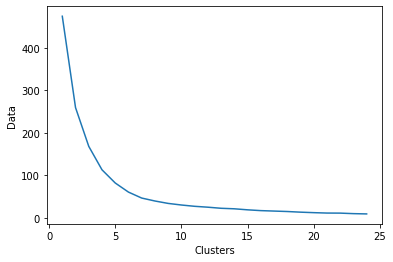

In [2]:
dataset = pd.read_csv('testdata-latlong.csv')
dataset_scaled = preprocessing.scale(dataset)
inertias = []

for number in range(1, 25):
    km = KMeans(number)
    km.fit(dataset_scaled)
    inertias.append(km.inertia_)

plt.plot(range(1, 25), inertias)
plt.xlabel('Clusters')
plt.ylabel('Data')

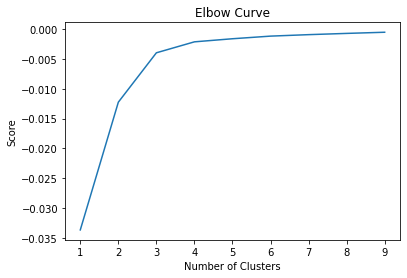

In [3]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters = i) for i in K_clusters]
Y_axis = dataset[['Lat ']]
X_axis = dataset[['Long']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

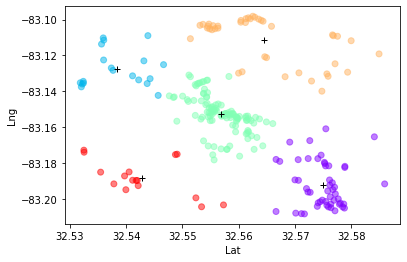

[[32.57492572549018, -83.19242633333332],
 [32.53844542105262, -83.12764815789474],
 [32.556799690909095, -83.1527655],
 [32.56453829268292, -83.111442097561],
 [32.5429105, -83.1882106875]]

In [5]:
#Choosing 5 clusters

km.fit(dataset_scaled)
km_new = KMeans(5)
dataset['Cluster'] = km_new.fit_predict(dataset_scaled)

centroids = []
for number in range(5):
    data_number = dataset[dataset['Cluster'] == number]
    data_number = data_number.reset_index()
    data_number = data_number.filter(['Lat ', 'Long', 'Cluster'])
    
    lat = []
    lng = []
    for index in range(len(data_number)):
        lat.append(data_number.iloc[index, 0])
        lng.append(data_number.iloc[index, 1])
    centroids.append([sum(lat)/len(lat), sum(lng)/len(lng)])
    
plt.scatter(dataset['Lat '], dataset['Long'], c = dataset['Cluster'], cmap = 'rainbow', alpha = 0.5)

for centroid in centroids:
    plt.plot(centroid[0], centroid[1], 'k+')

plt.xlabel('Lat')
plt.ylabel('Lng')
plt.show()

centroids

In [6]:
dataset['Distance(km)'] = None
dataset['Store-Lat'] = None
dataset['Store-Lng'] = None

for index in range(len(dataset)):
    lat = dataset.iloc[index, 0]
    lng = dataset.iloc[index, 1]
    distances = []
    
    for centroid in centroids:
        distances.append(geopy.distance.distance((lat, lng), (centroid[0], centroid[1])).km)
    dataset.at[index, 'Distance(km)'] = min(distances)
    dataset.at[index, 'Store-Lat'] = centroids[distances.index(min(distances))][0]
    dataset.at[index, 'Store-Lng'] = centroids[distances.index(min(distances))][1]

print('Houses further than 1.5 km - {}'.format(len(dataset[dataset['Distance(km)'] > 1.5])))
dataset

Houses further than 1.5 km - 52


,Lat,Long,Cluster,Distance(km),Store-Lat,Store-Lng
0,32.549009,-83.156737,2,0.941044,32.5568,-83.152766
1,32.553748,-83.167706,2,1.443434,32.5568,-83.152766
2,32.553282,-83.155563,2,0.47033,32.5568,-83.152766
3,32.552286,-83.153496,2,0.505233,32.5568,-83.152766
4,32.553519,-83.154454,2,0.396877,32.5568,-83.152766
...,...,...,...,...,...,...
232,32.563984,-83.100397,3,1.039064,32.564538,-83.111442
233,32.561700,-83.099013,3,1.208924,32.564538,-83.111442
234,32.563527,-83.099718,3,1.106708,32.564538,-83.111442
235,32.562853,-83.098677,3,1.213257,32.564538,-83.111442


In [7]:
dataset.to_csv('cluster & distance dataset')

<ipython-input-8-8b051464a559>:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (10,4))


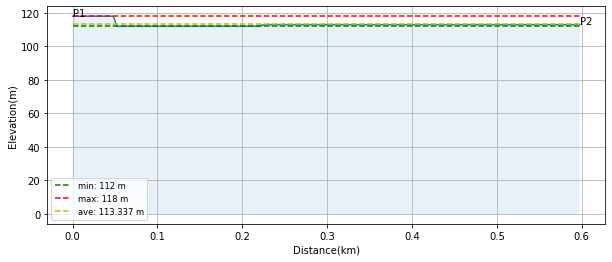

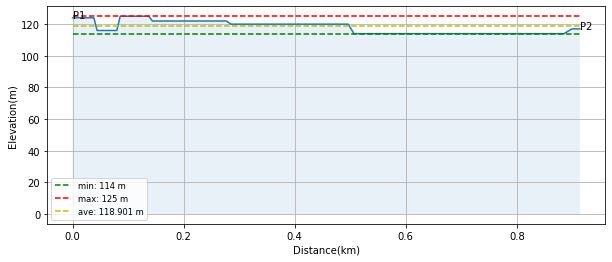

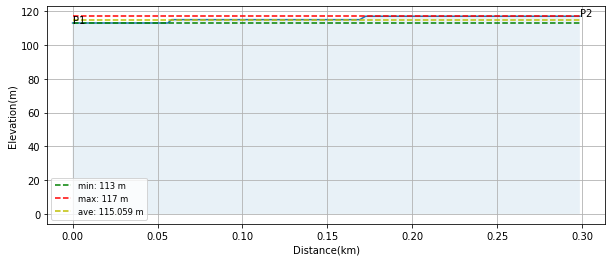

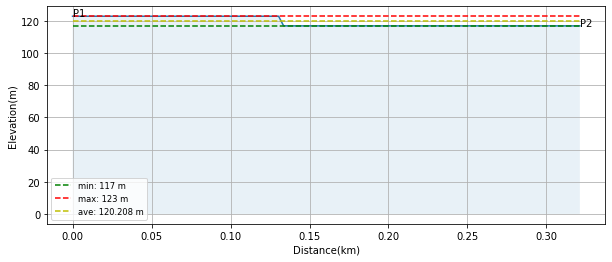

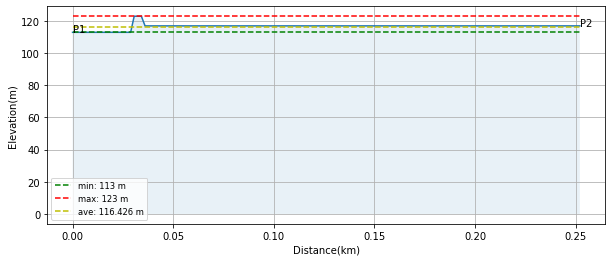

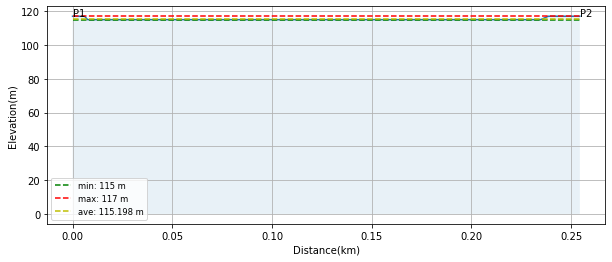

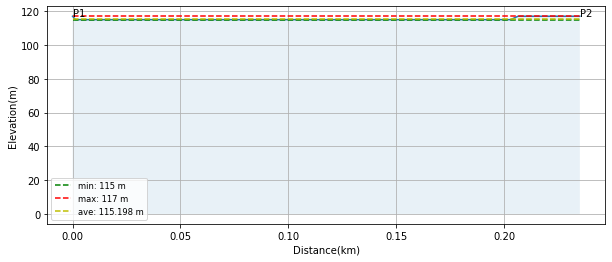

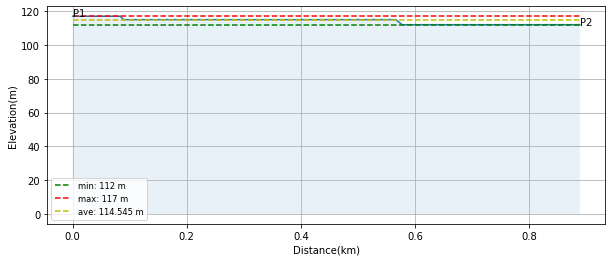

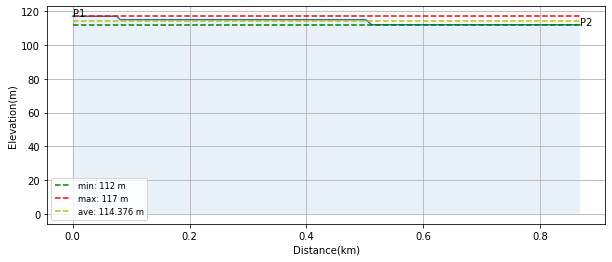

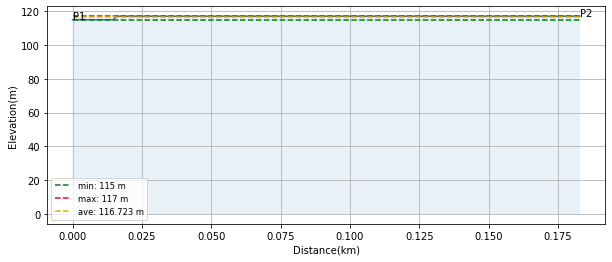

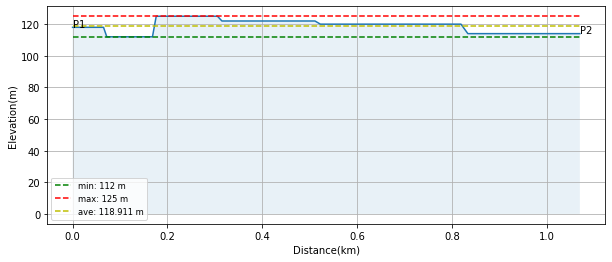

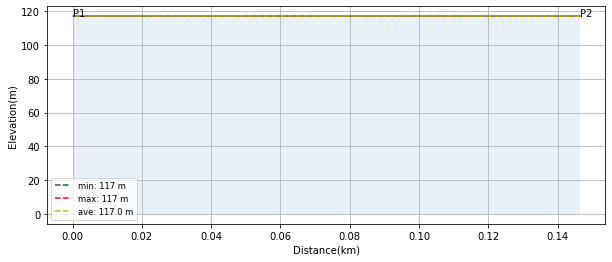

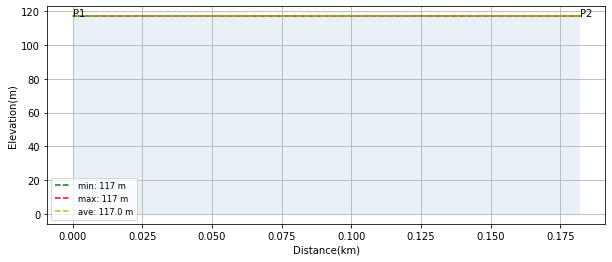

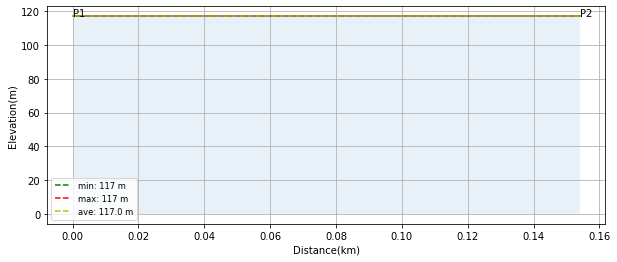

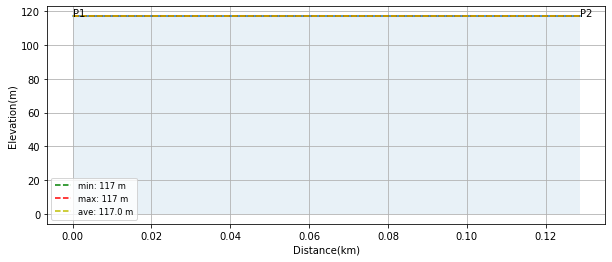

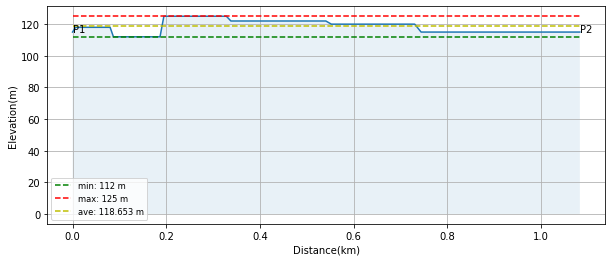

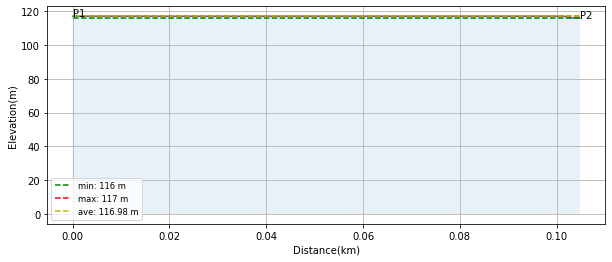

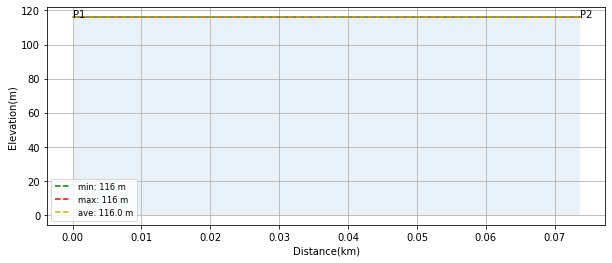

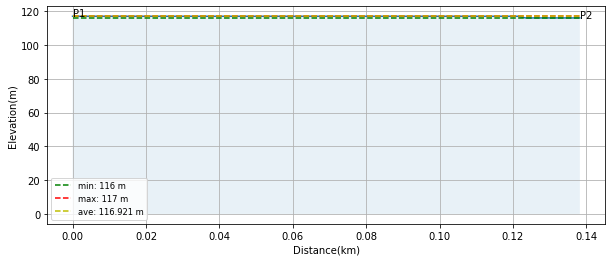

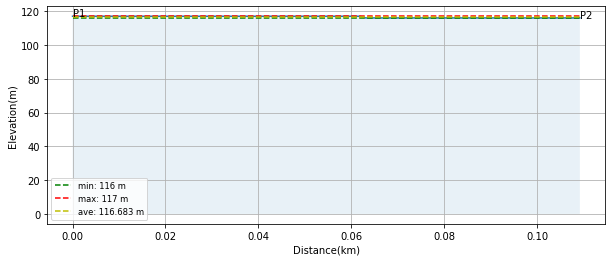

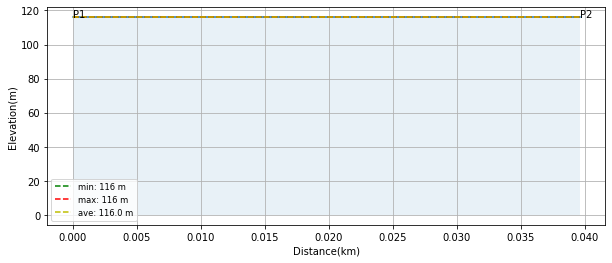

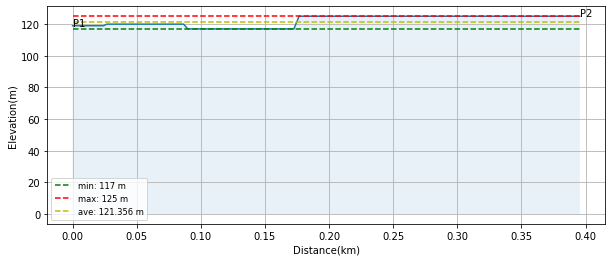

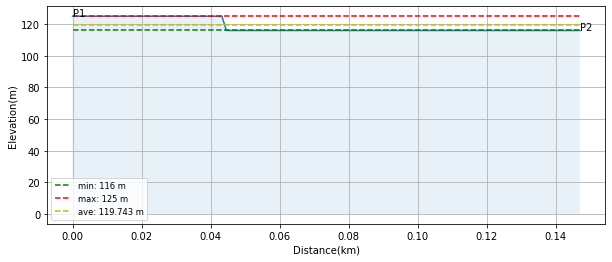

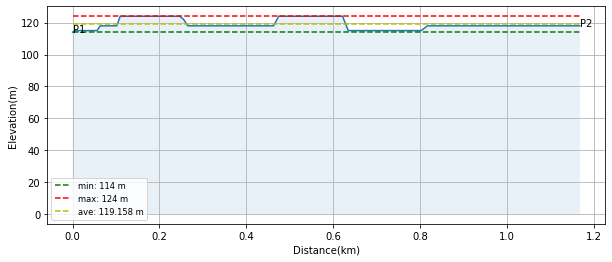

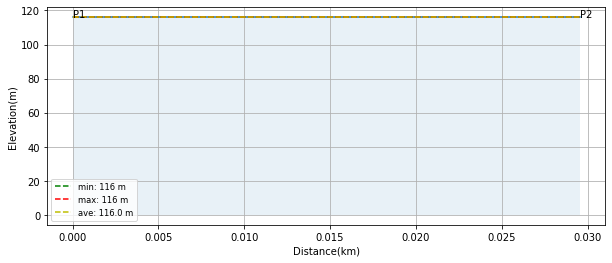

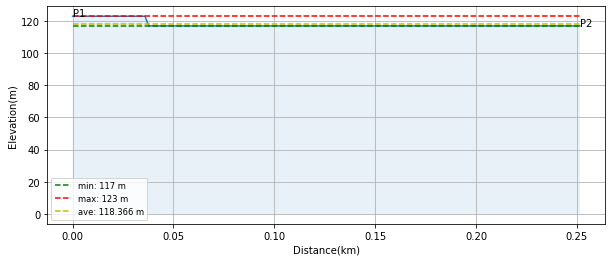

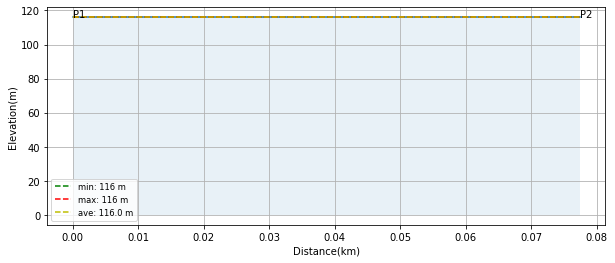

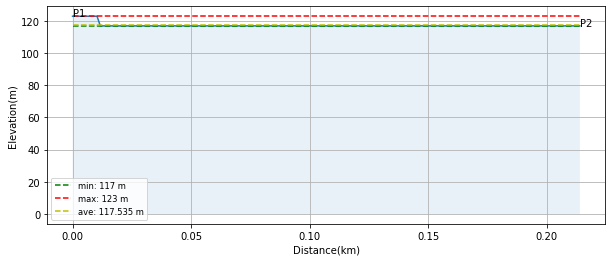

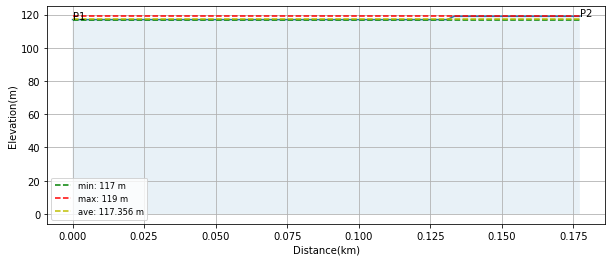

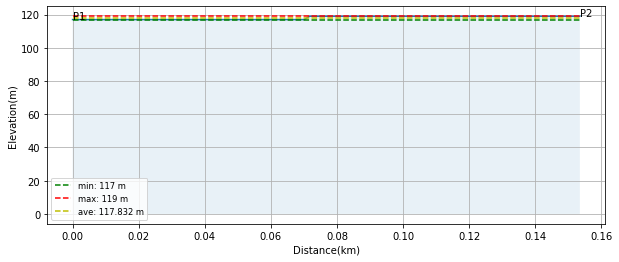

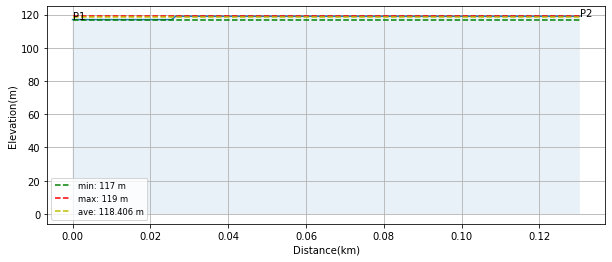

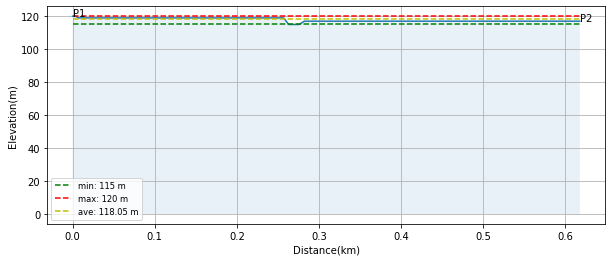

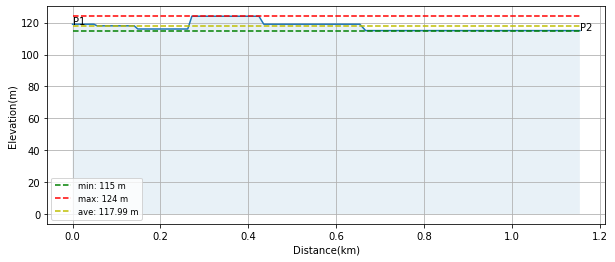

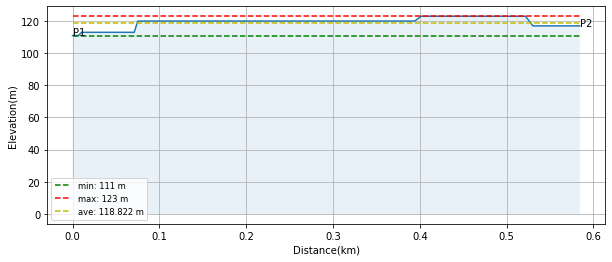

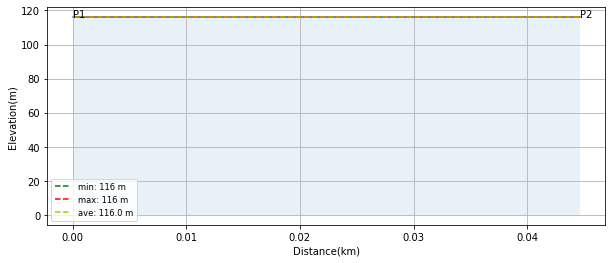

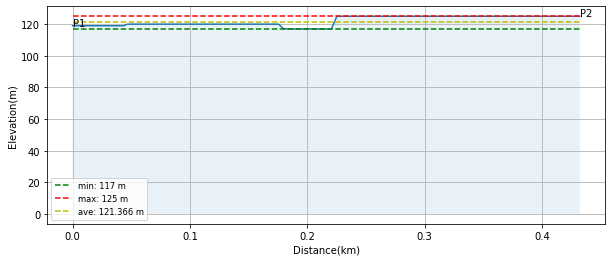

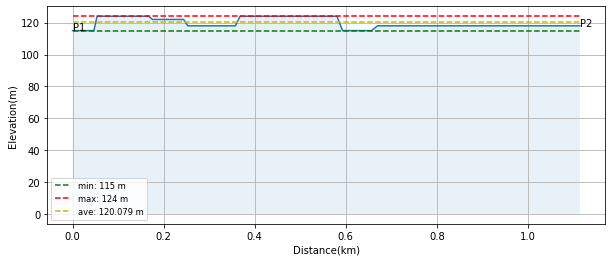

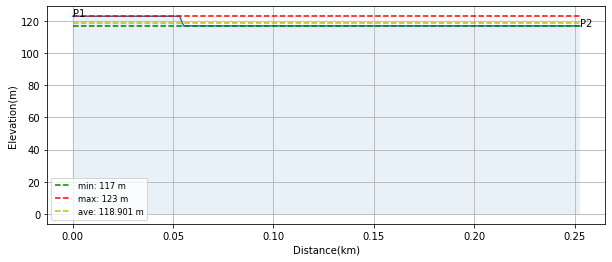

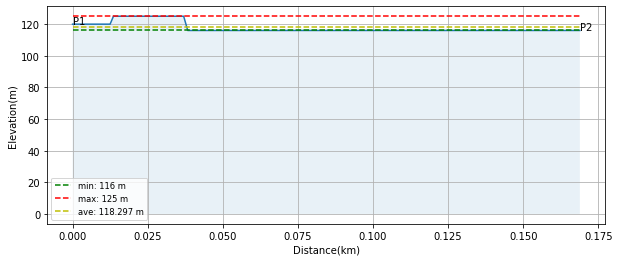

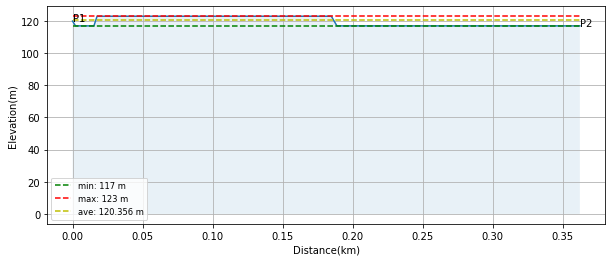

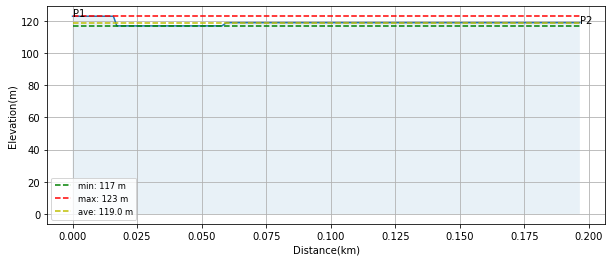

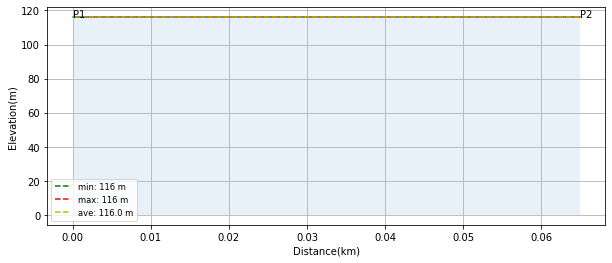

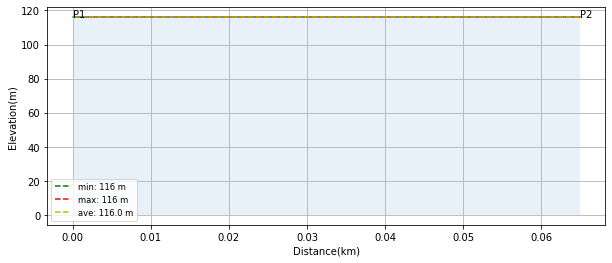

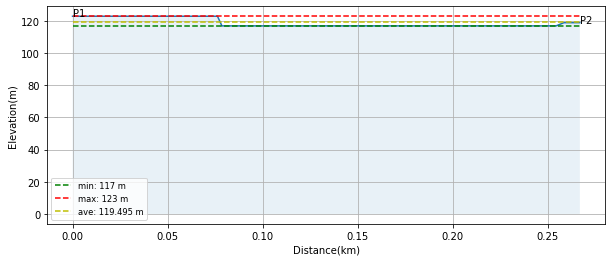

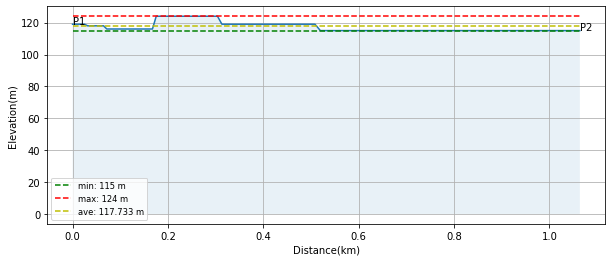

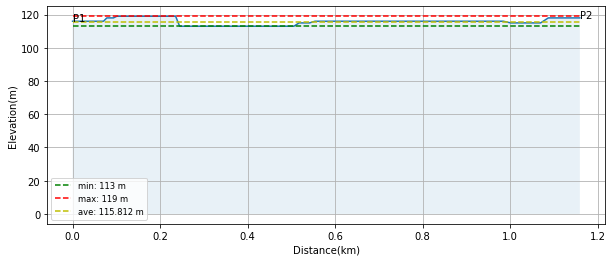

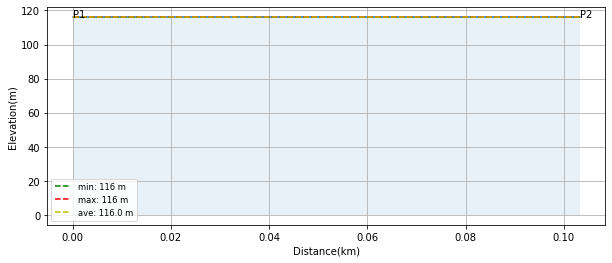

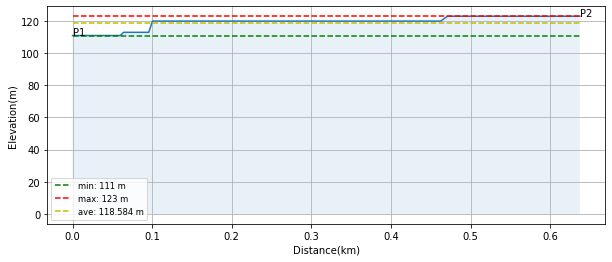

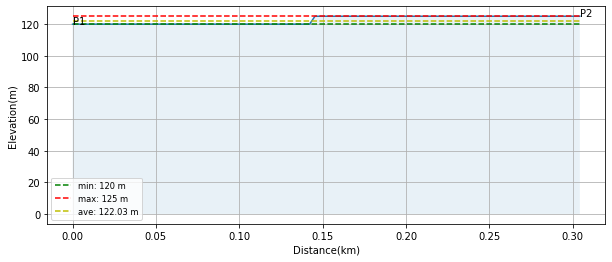

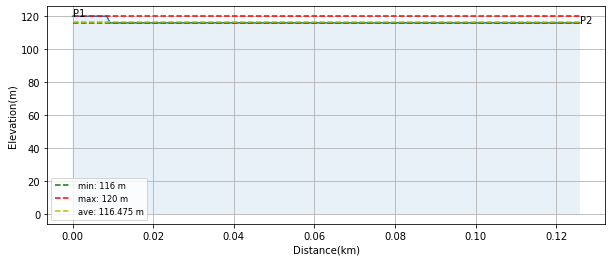

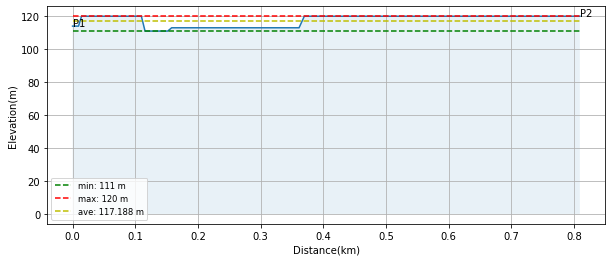

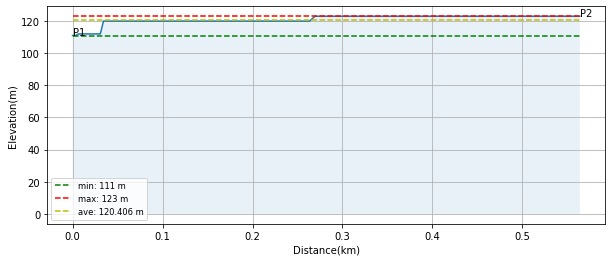

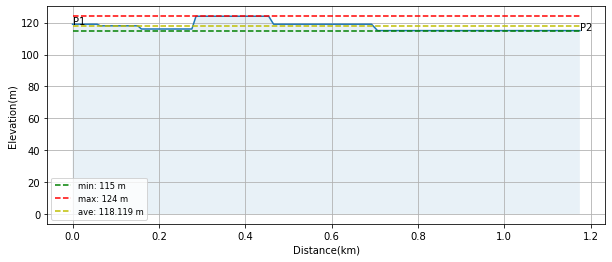

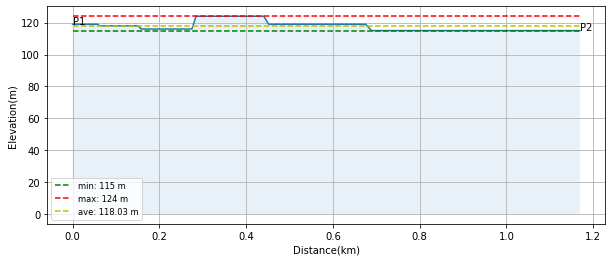

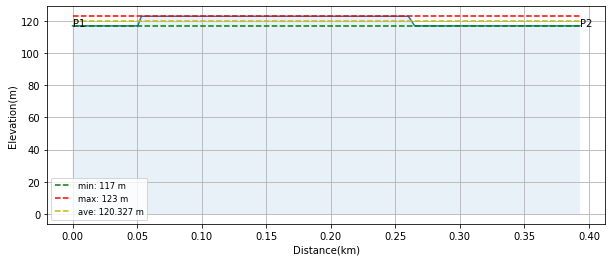

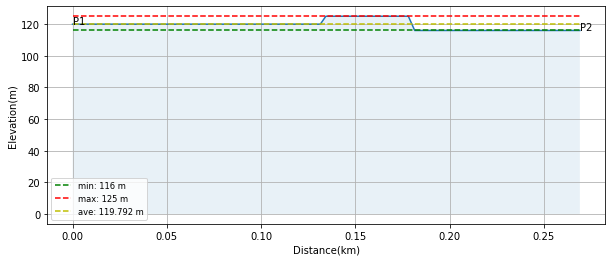

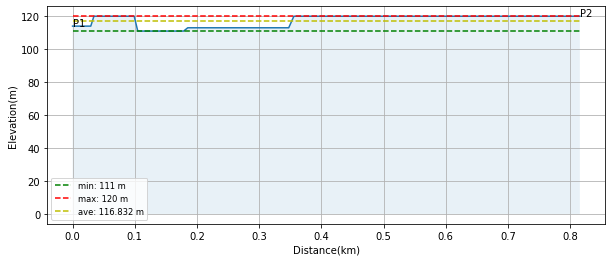

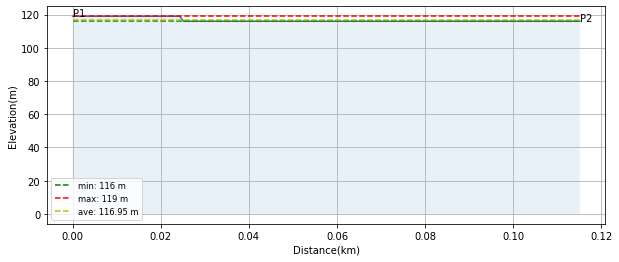

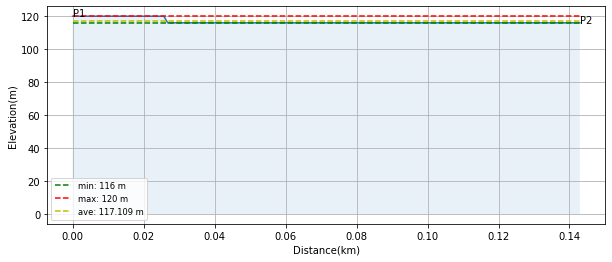

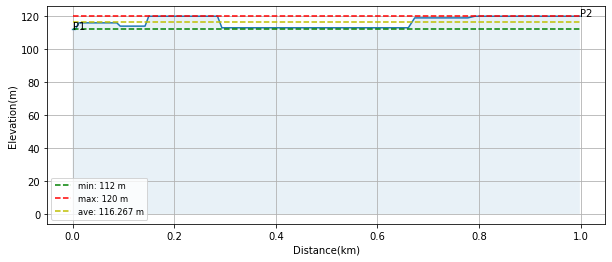

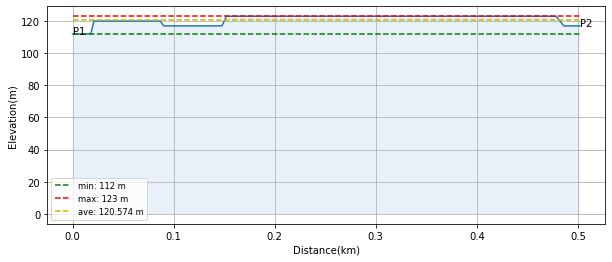

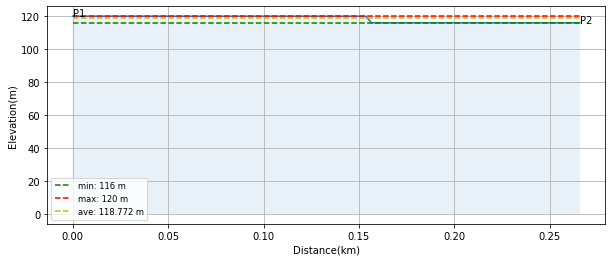

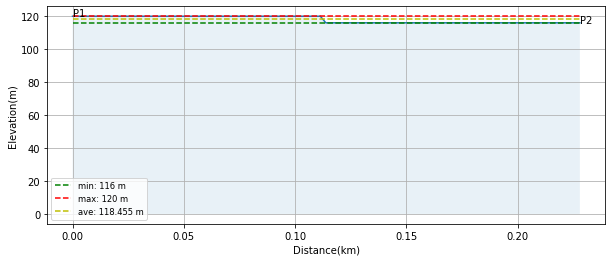

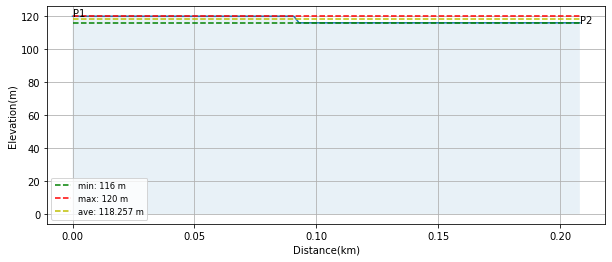

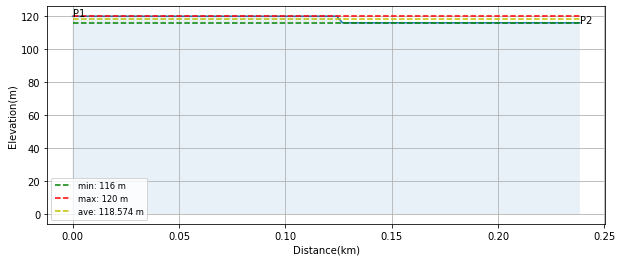

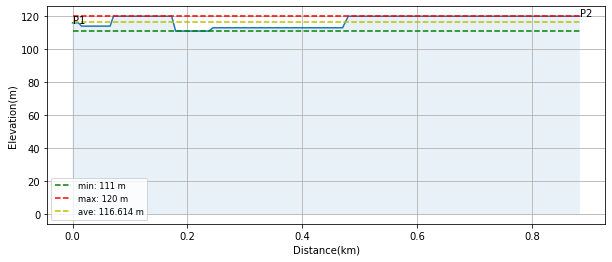

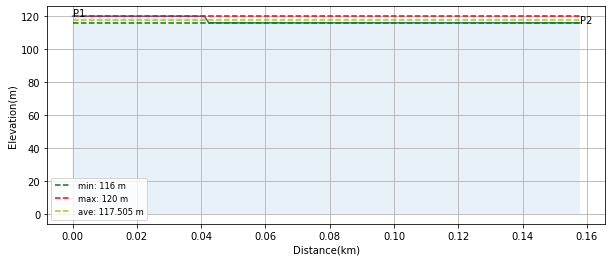

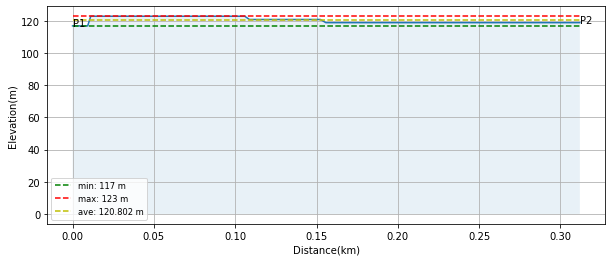

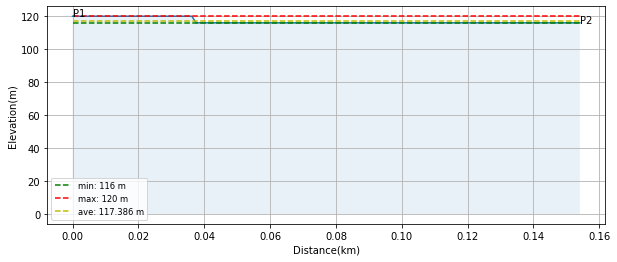

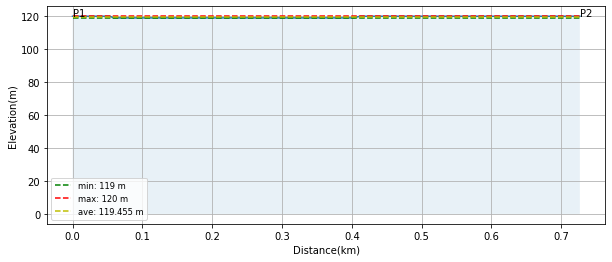

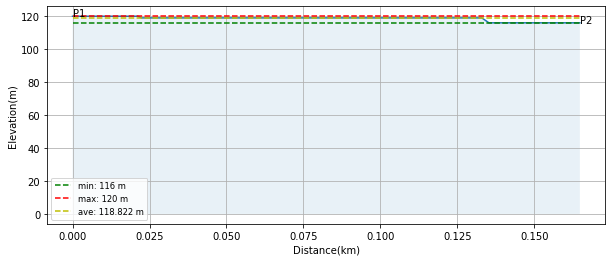

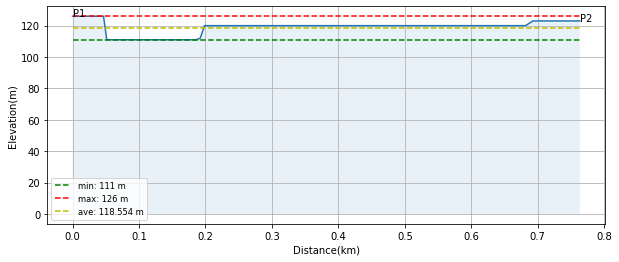

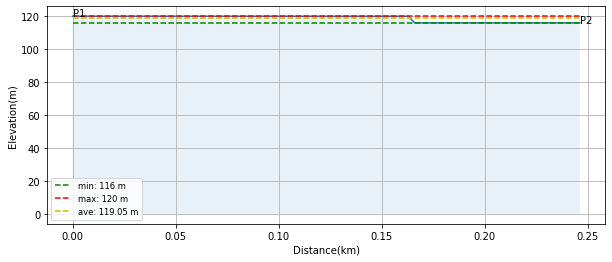

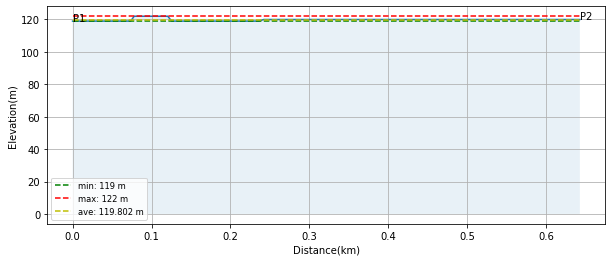

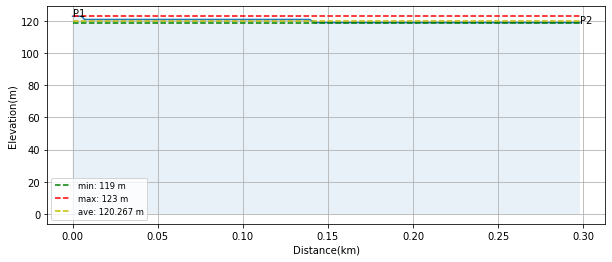

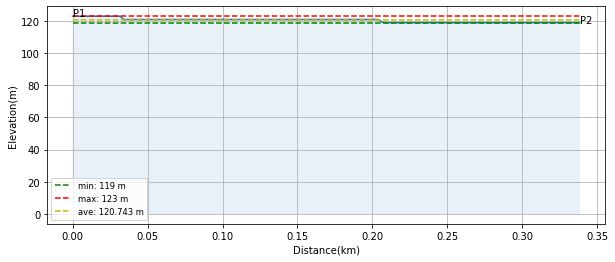

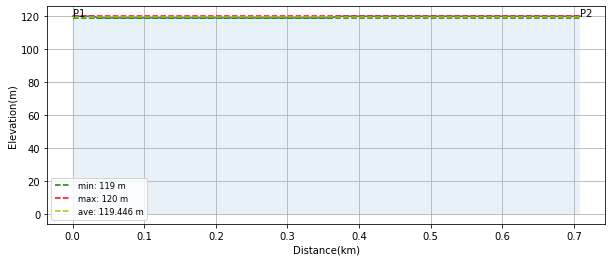

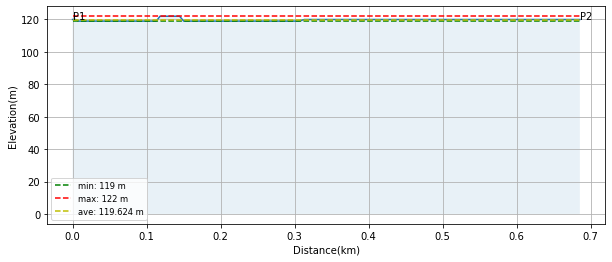

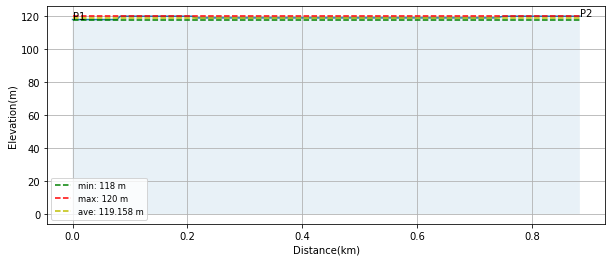

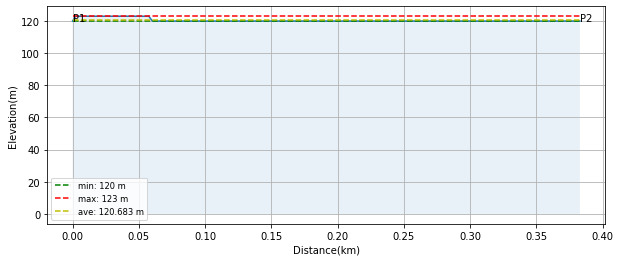

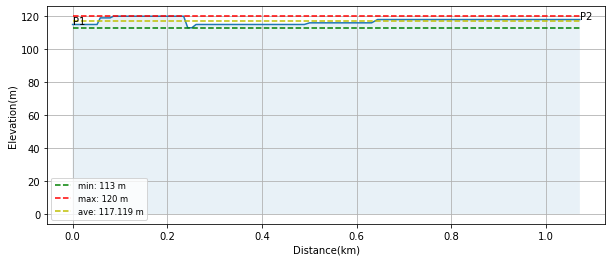

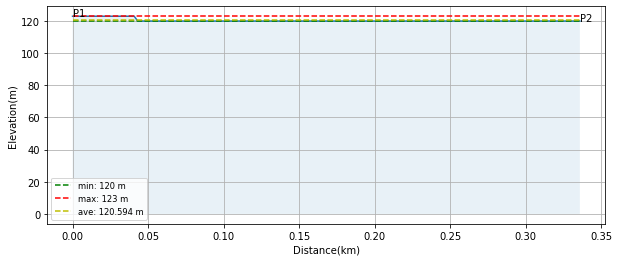

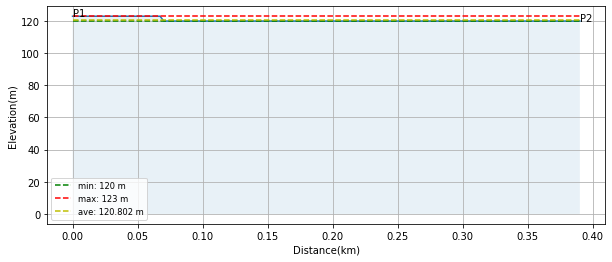

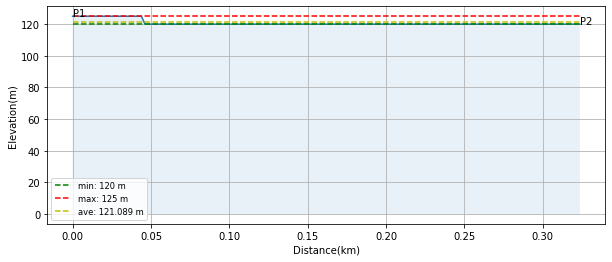

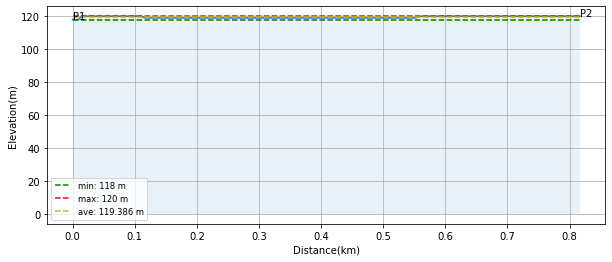

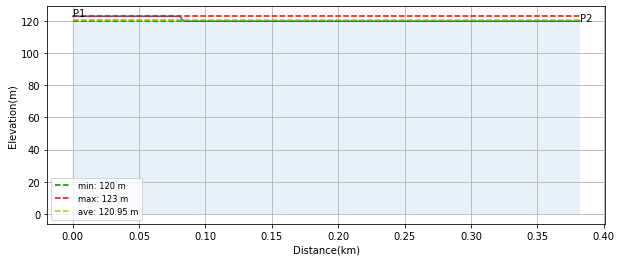

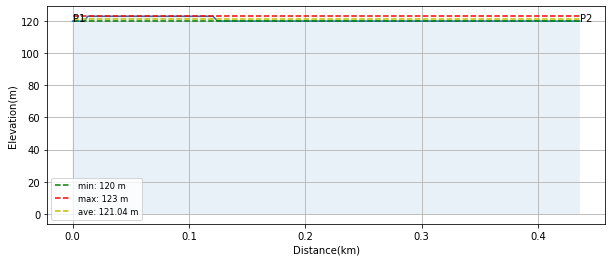

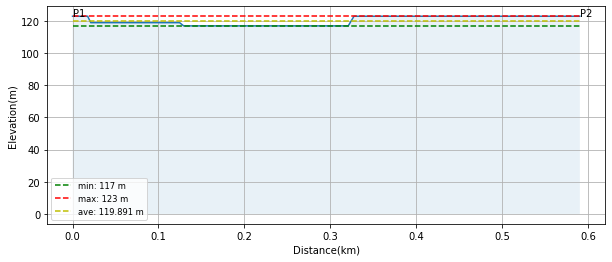

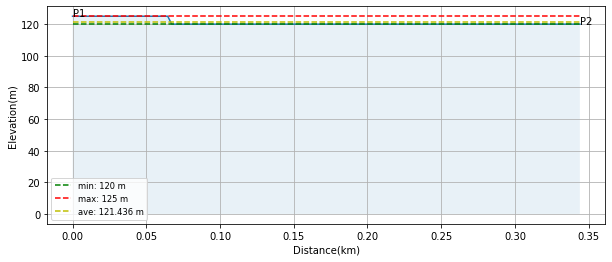

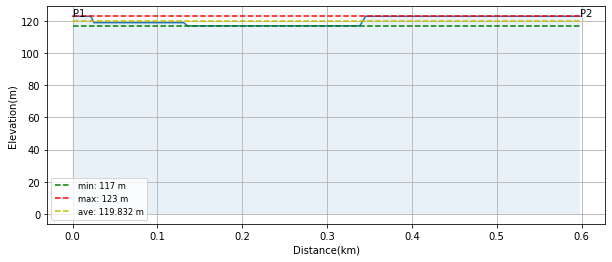

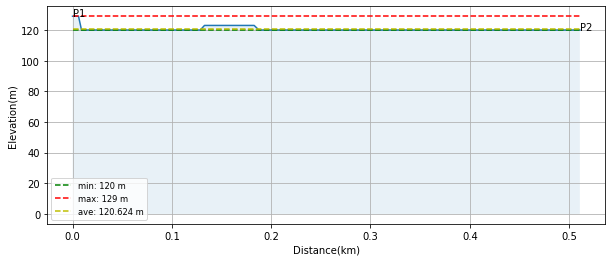

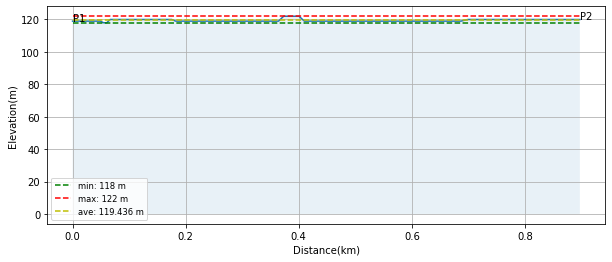

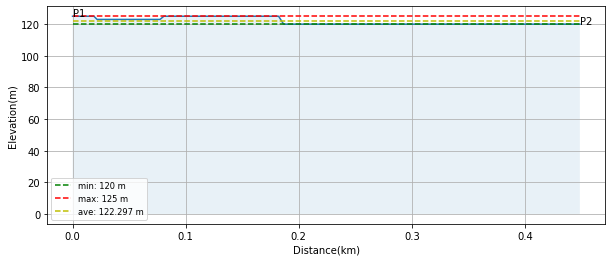

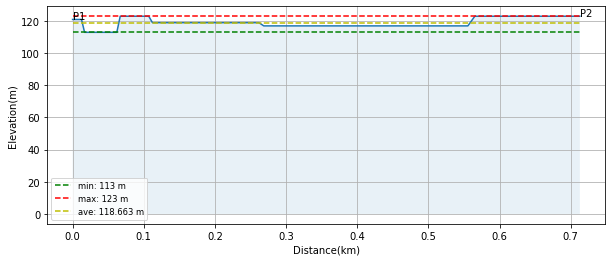

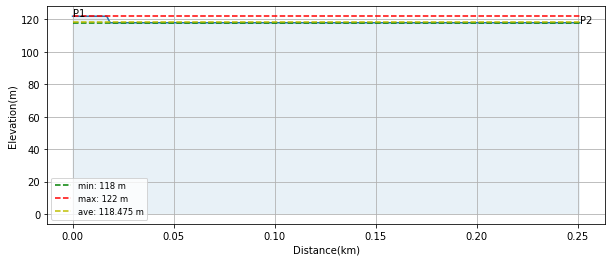

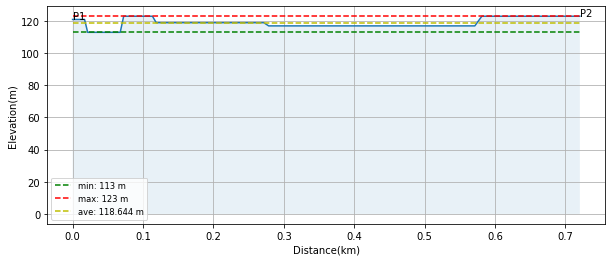

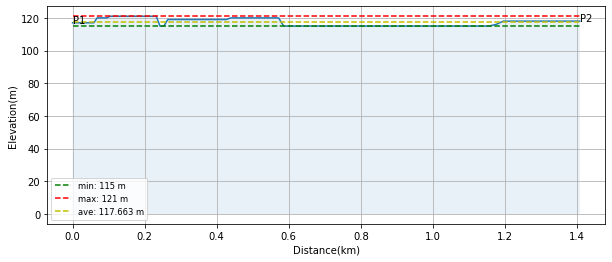

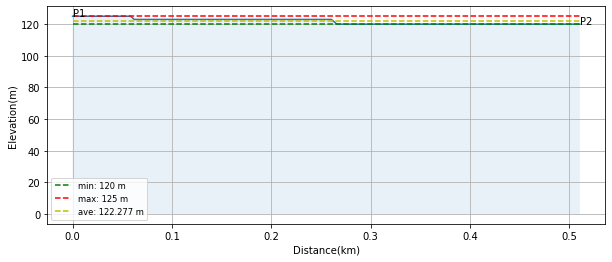

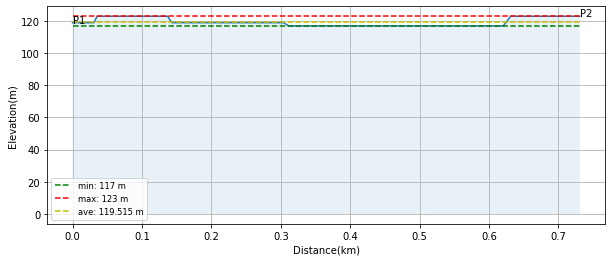

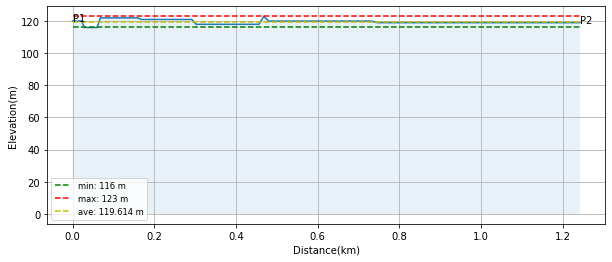

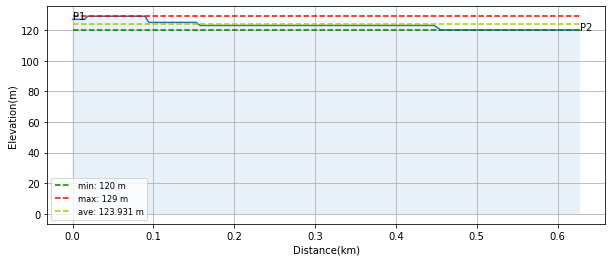

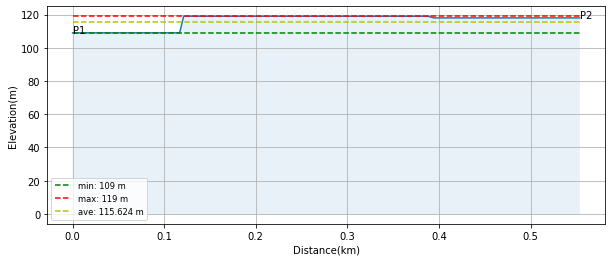

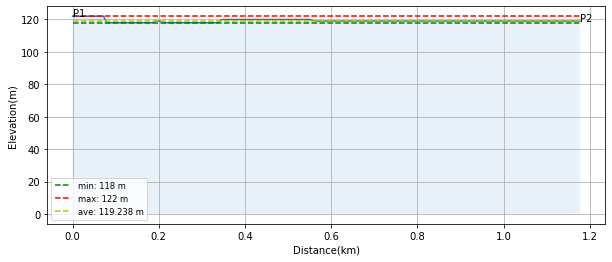

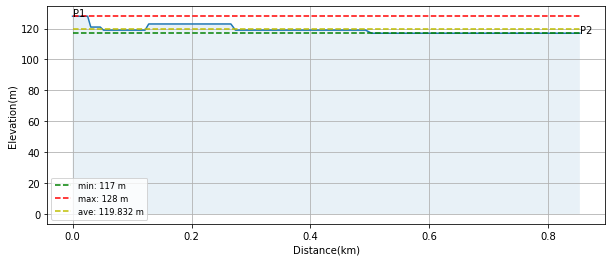

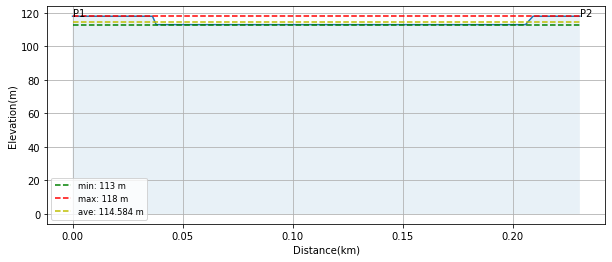

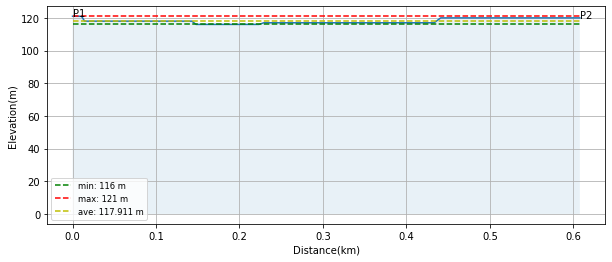

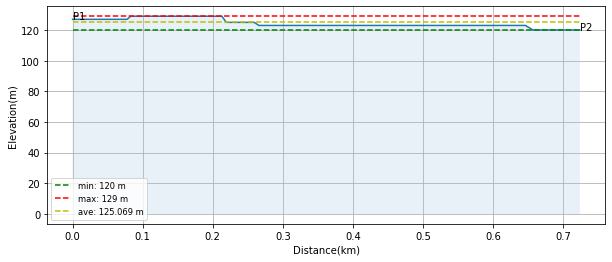

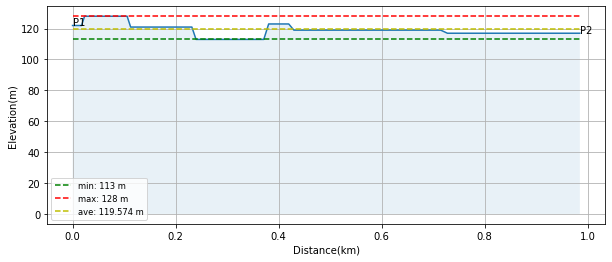

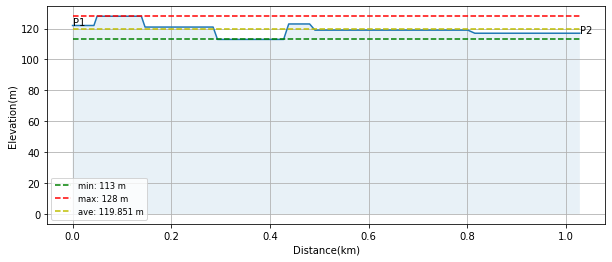

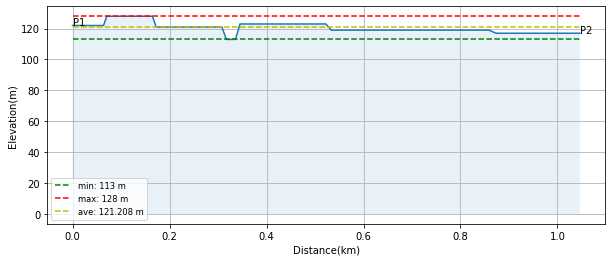

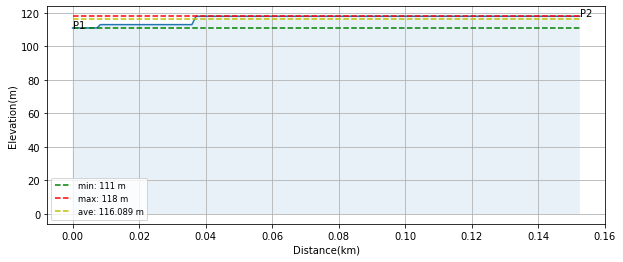

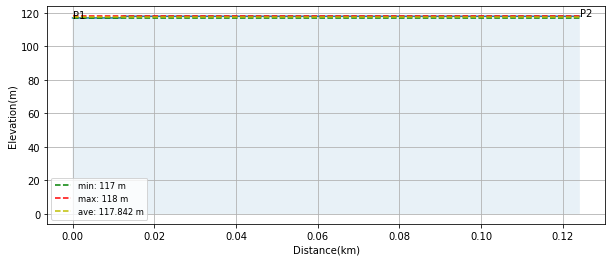

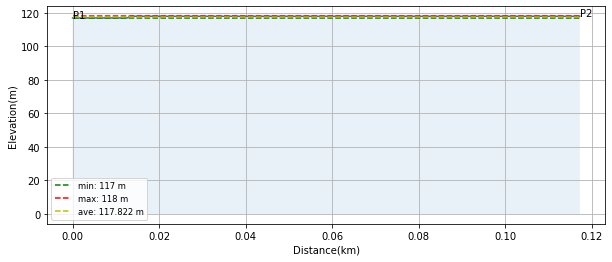

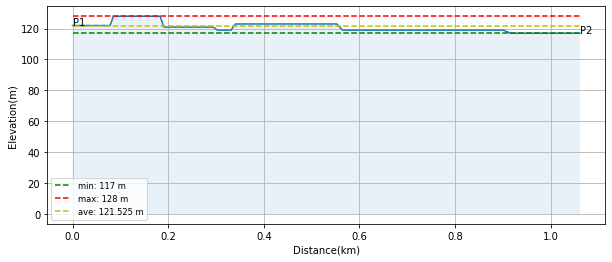

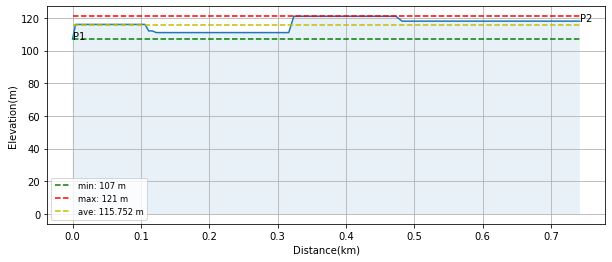

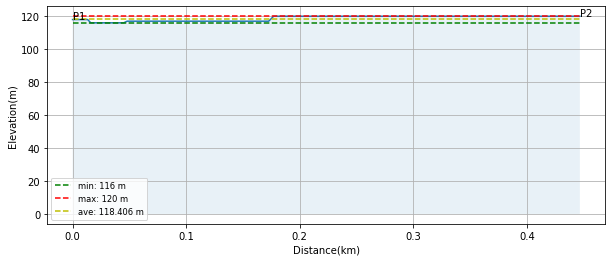

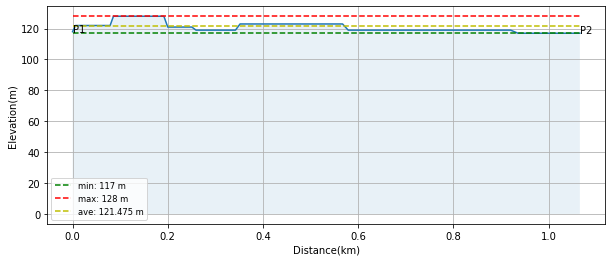

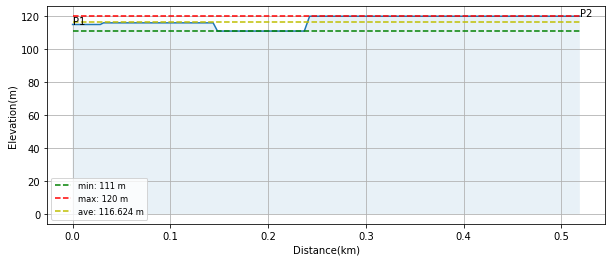

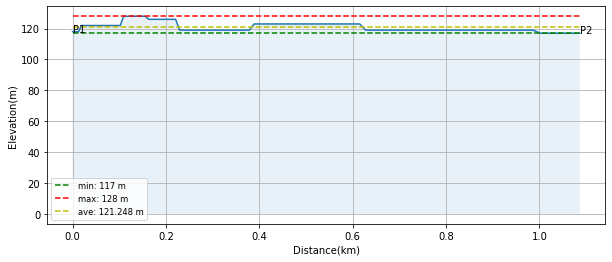

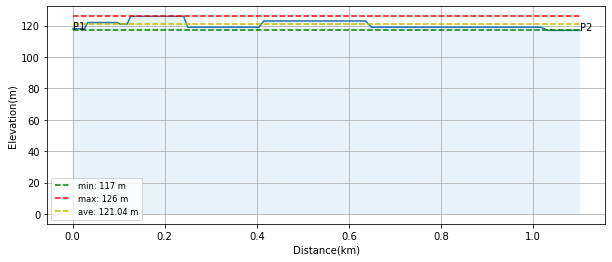

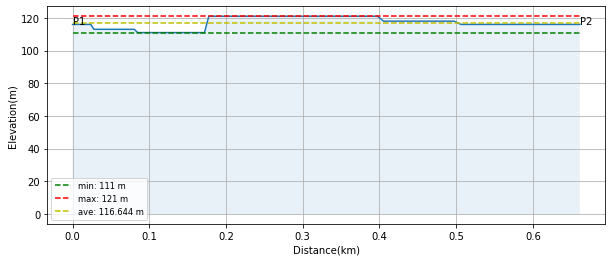

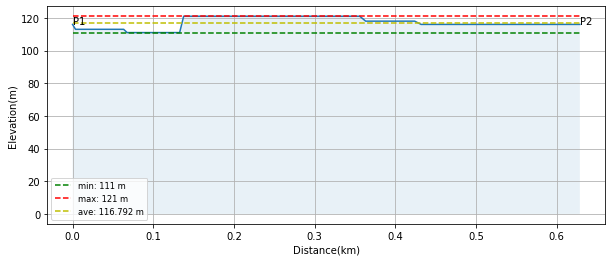

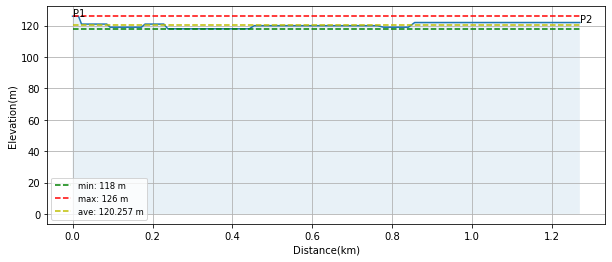

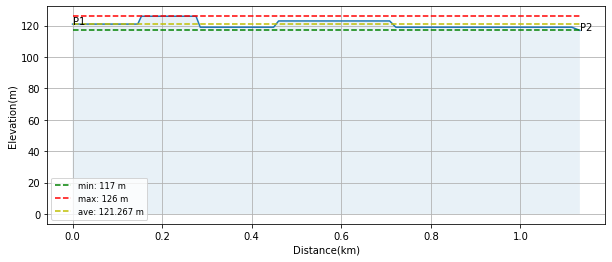

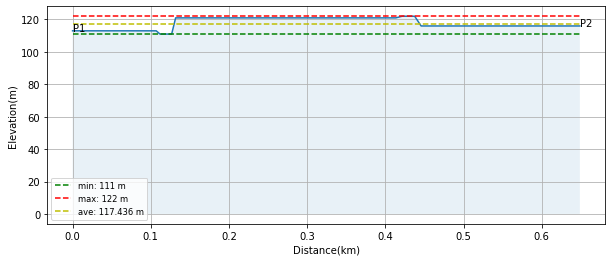

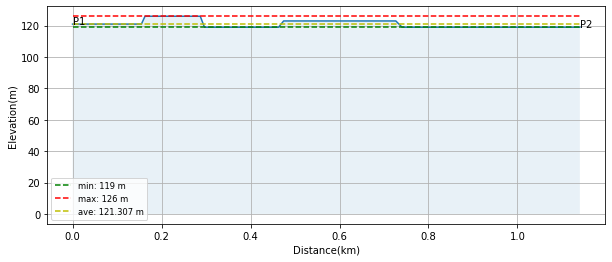

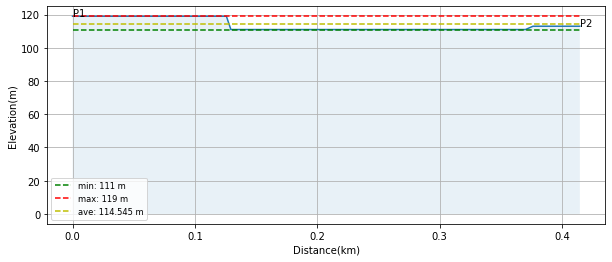

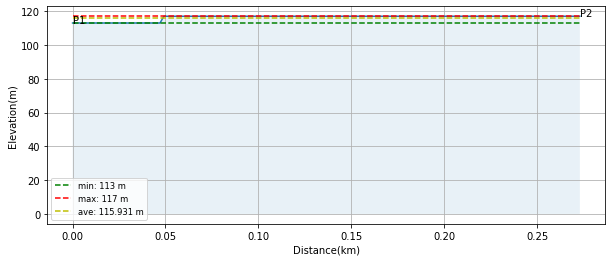

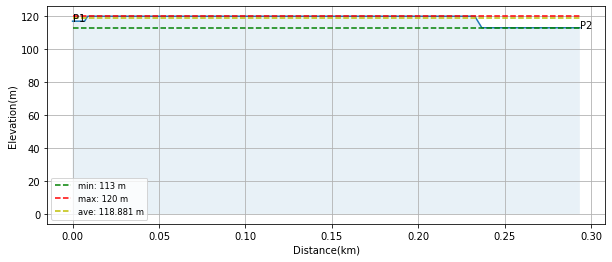

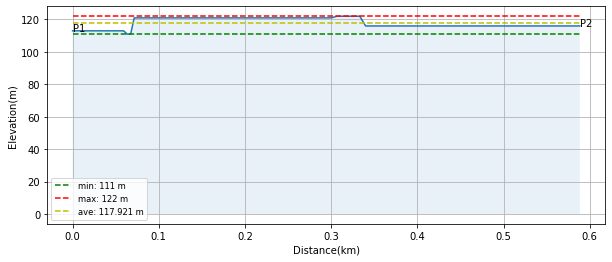

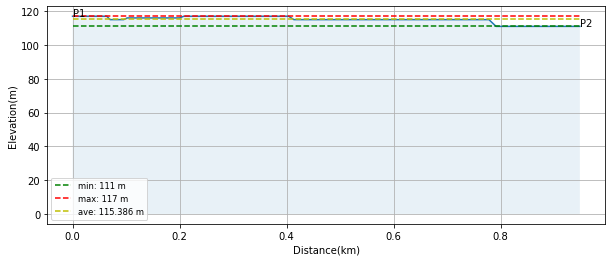

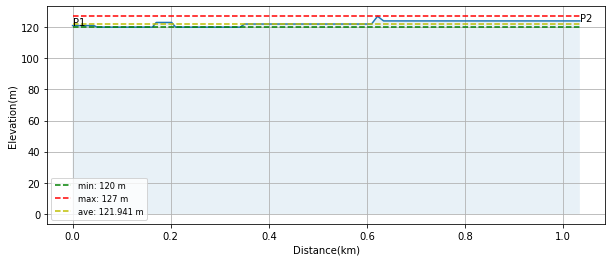

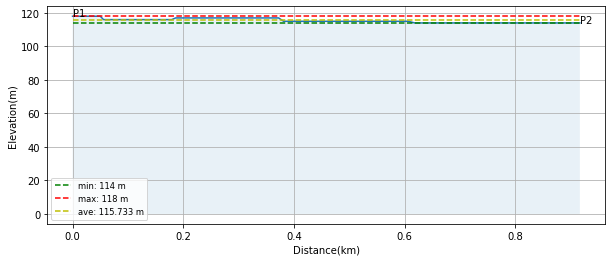

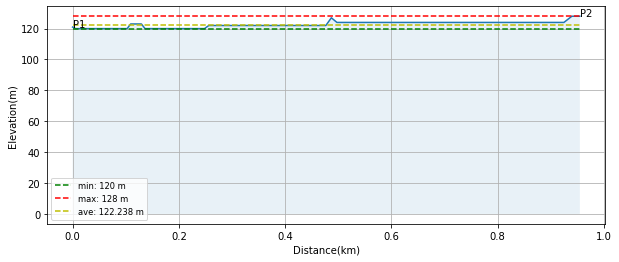

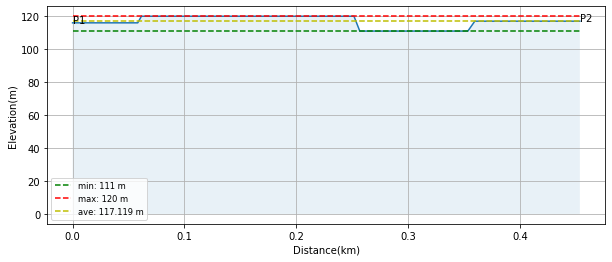

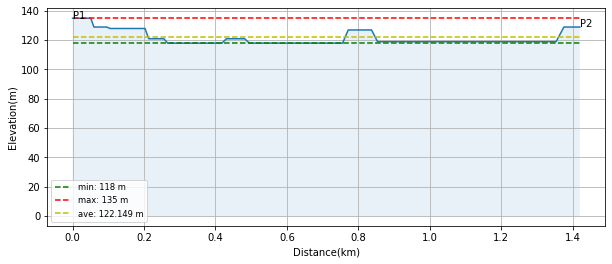

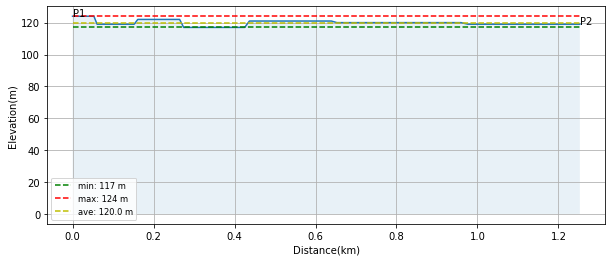

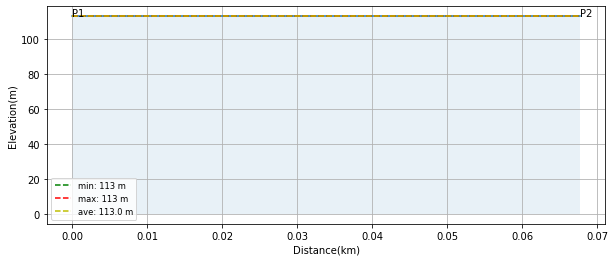

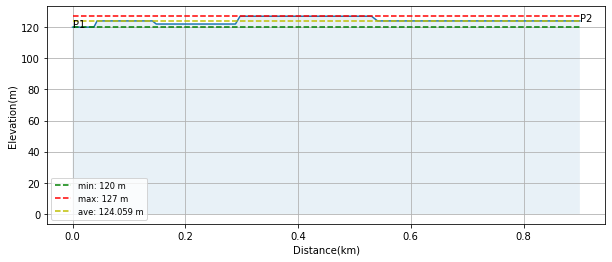

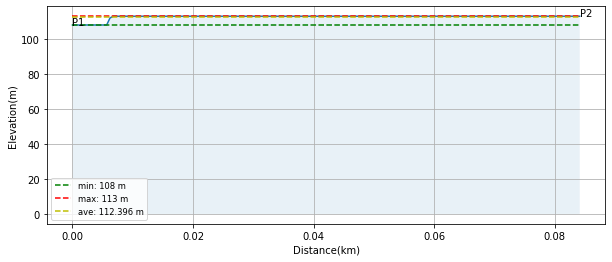

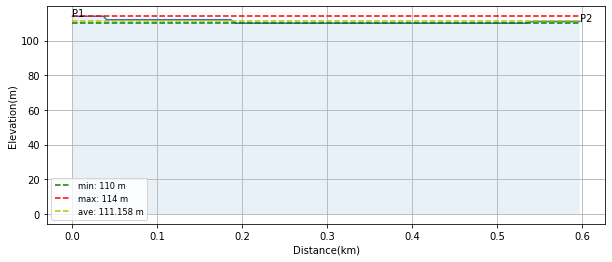

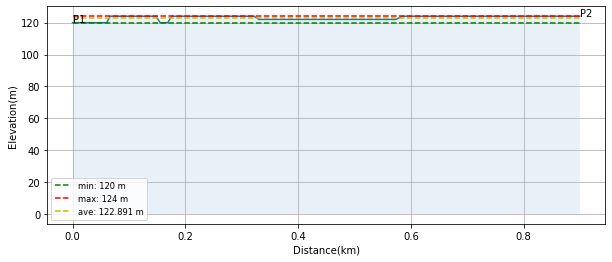

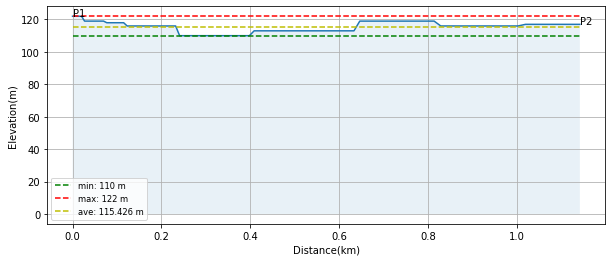

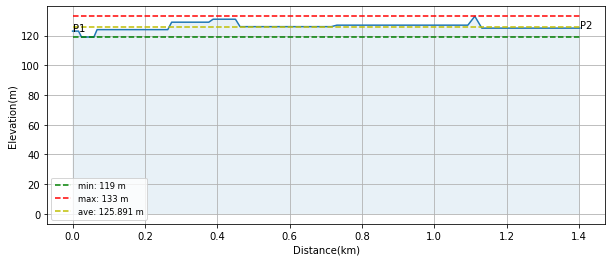

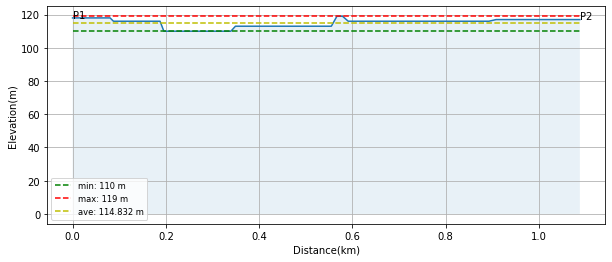

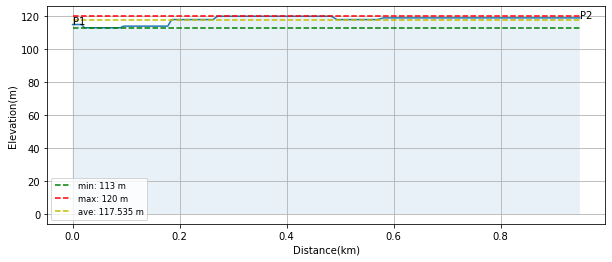

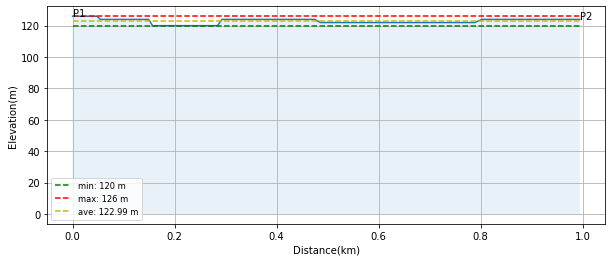

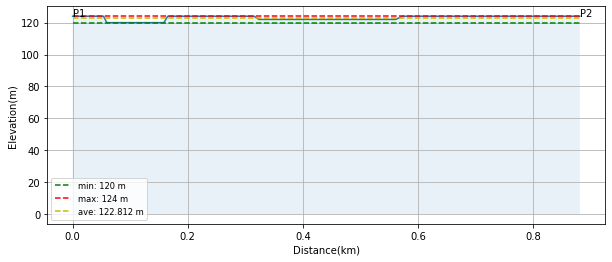

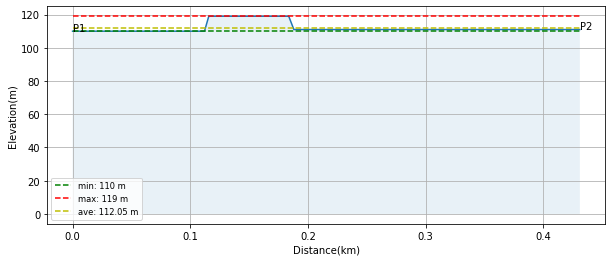

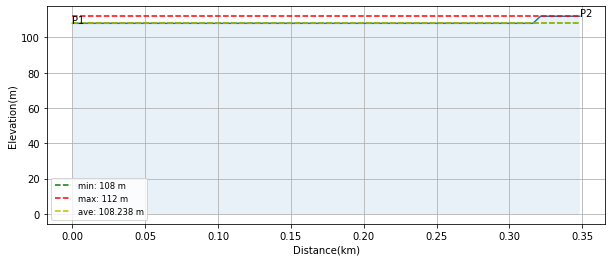

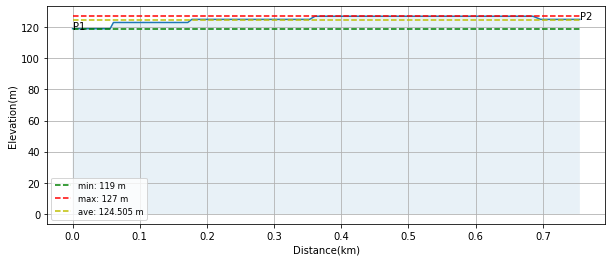

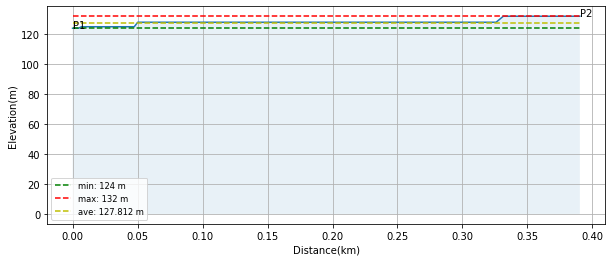

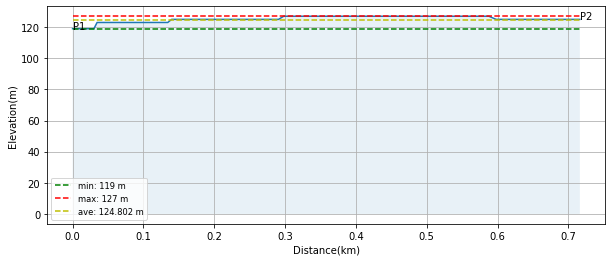

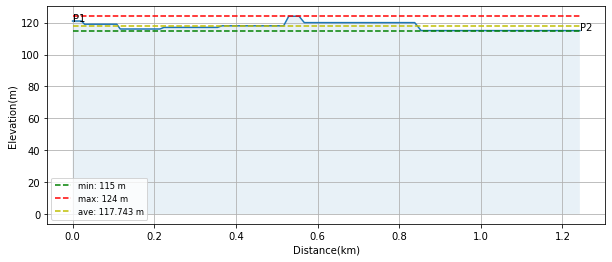

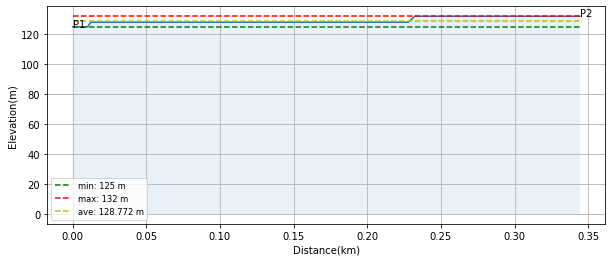

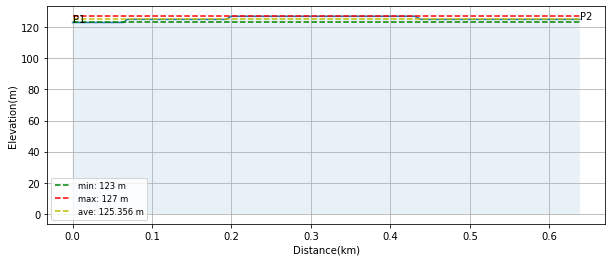

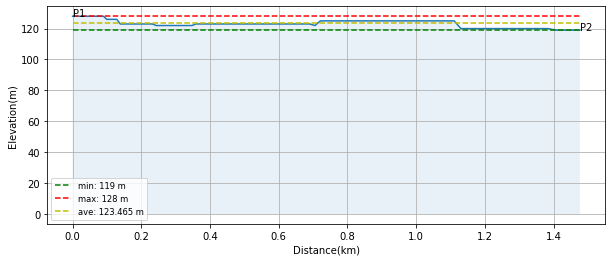

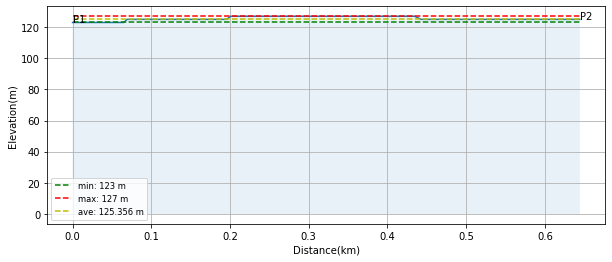

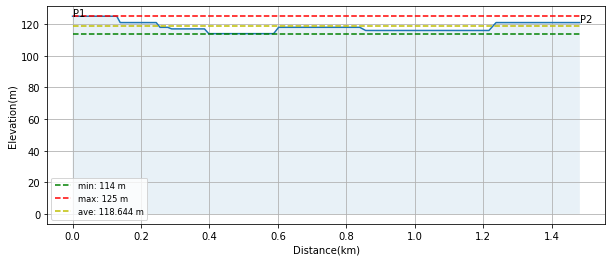

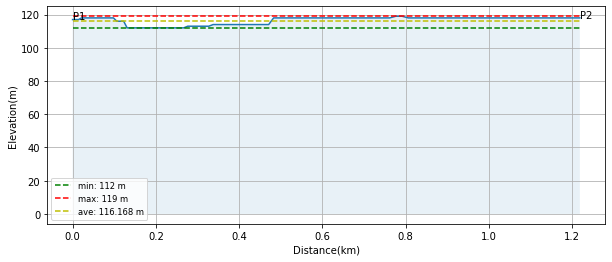

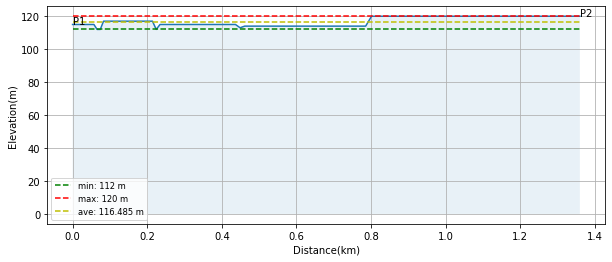

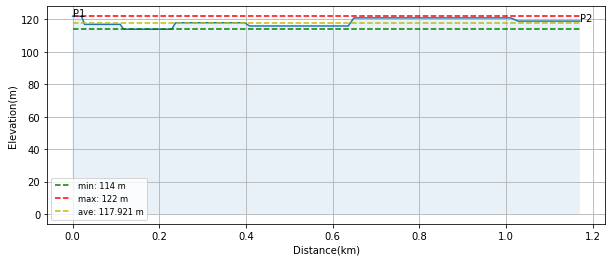

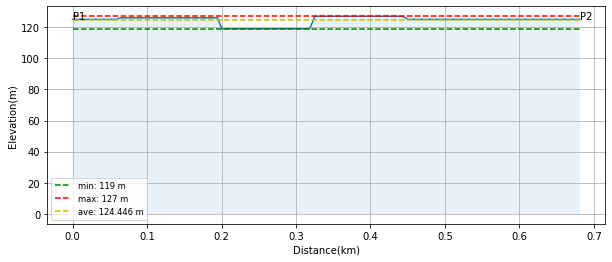

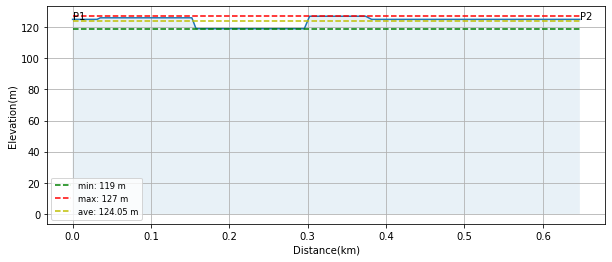

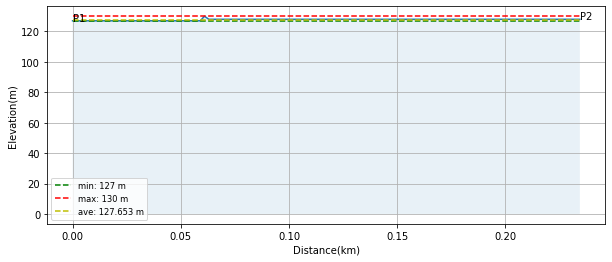

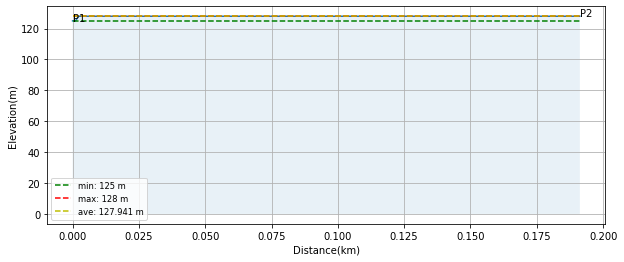

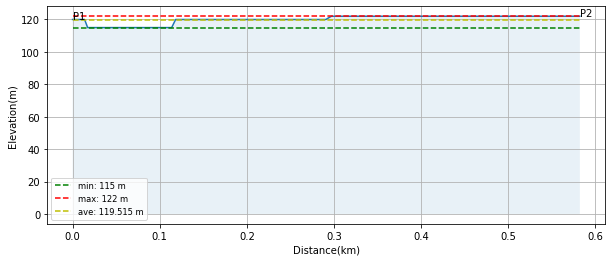

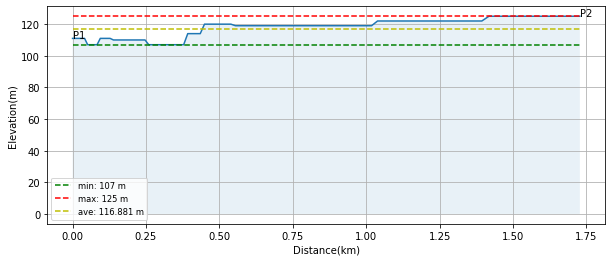

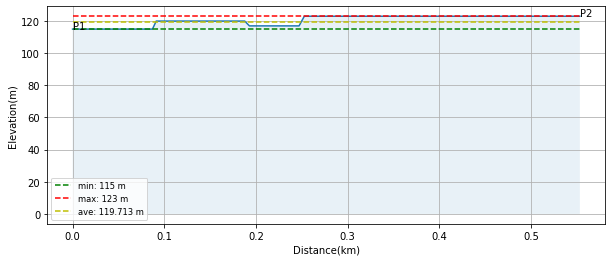

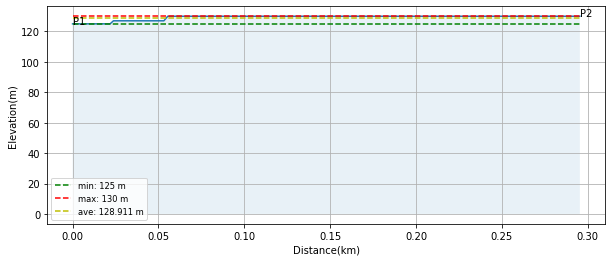

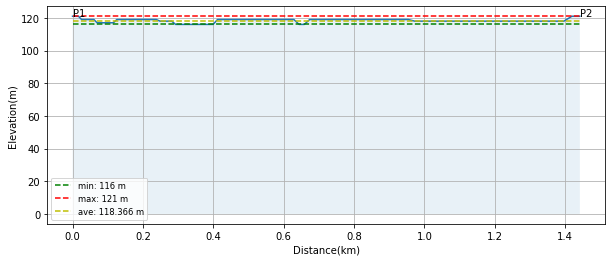

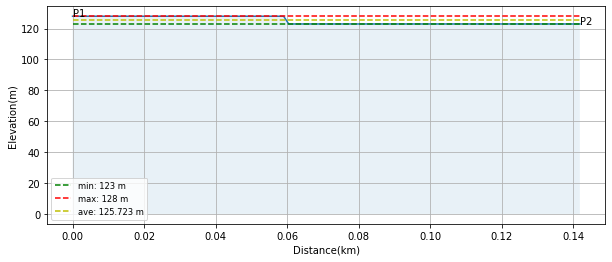

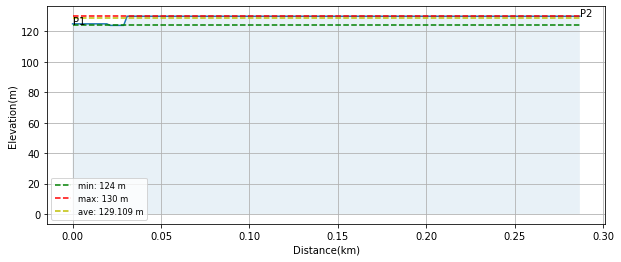

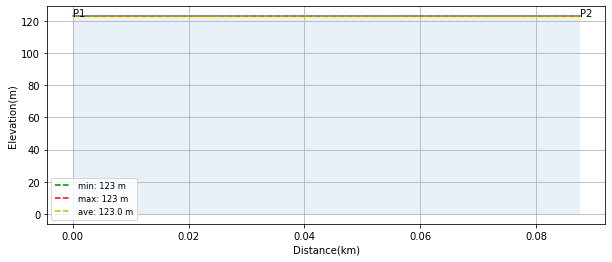

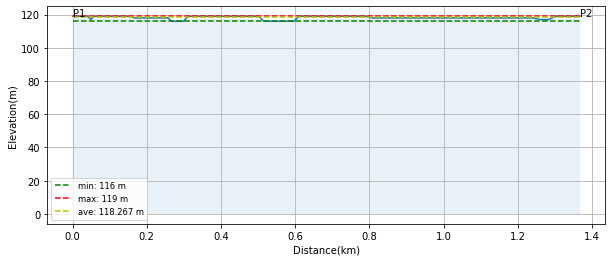

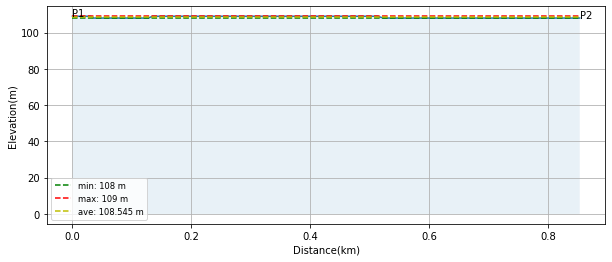

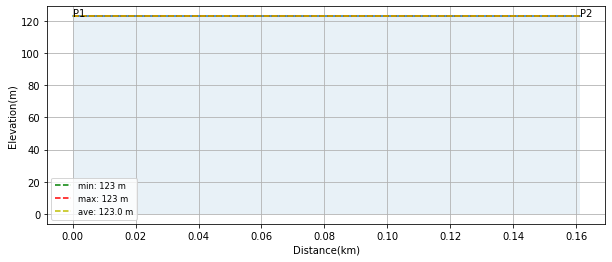

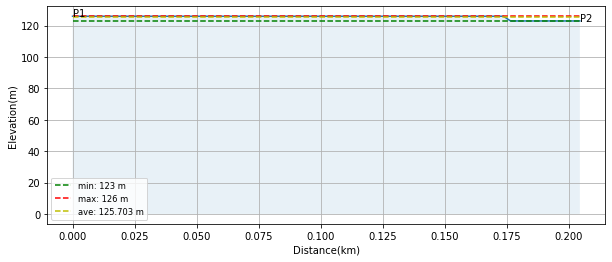

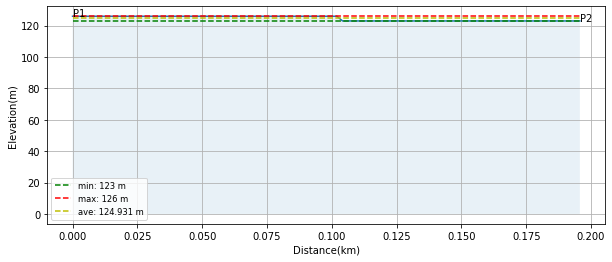

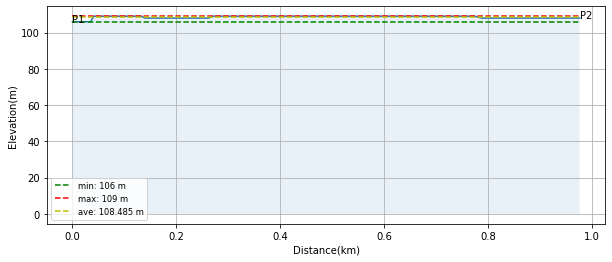

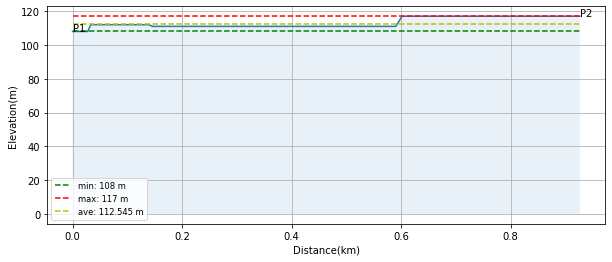

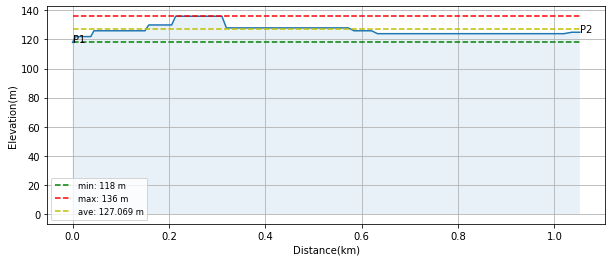

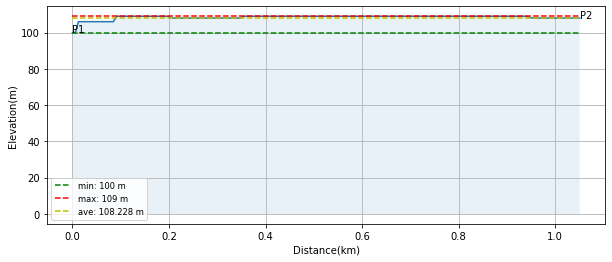

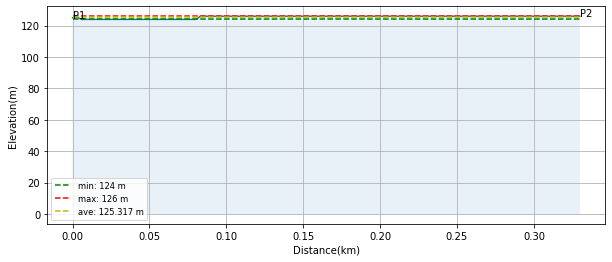

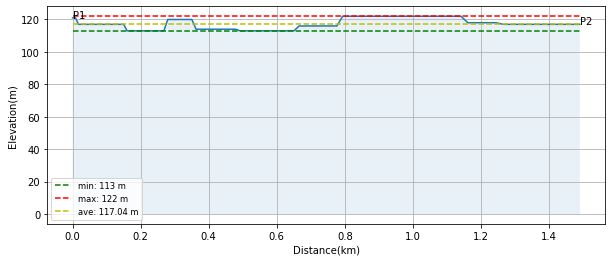

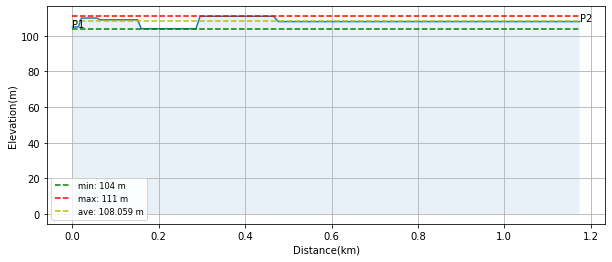

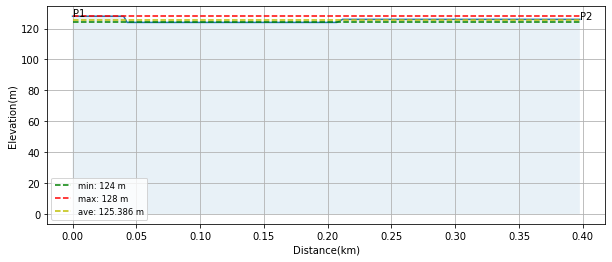

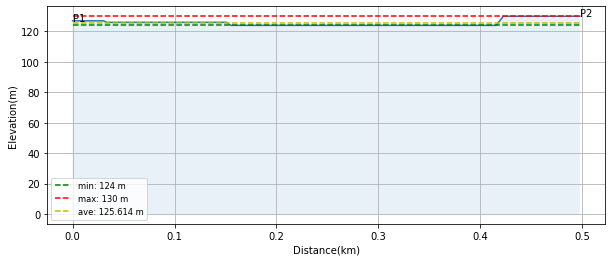

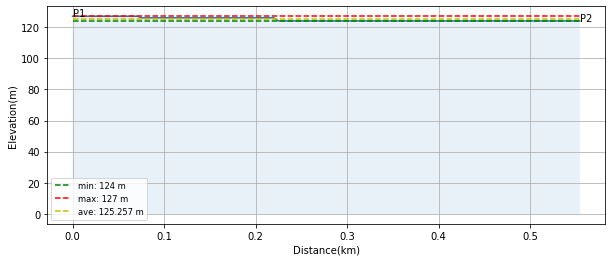

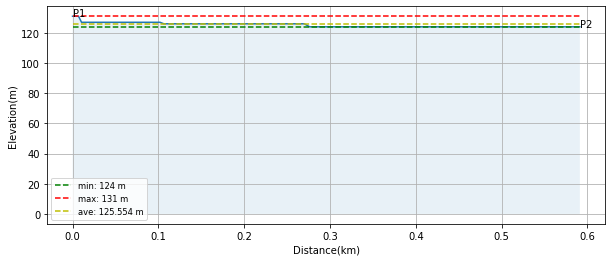

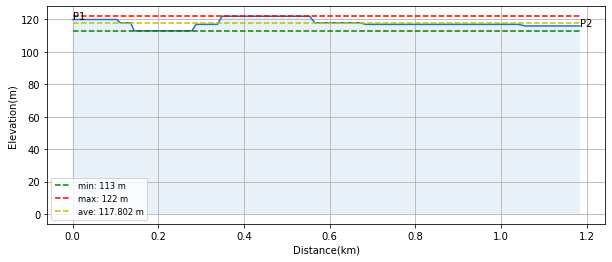

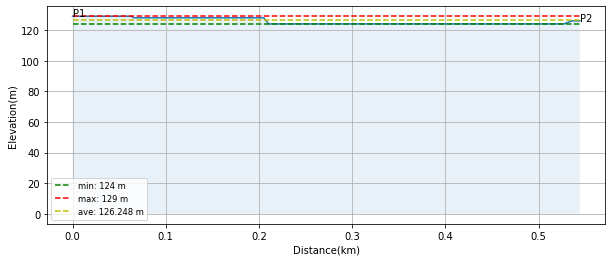

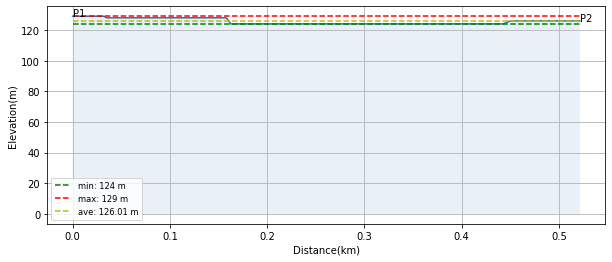

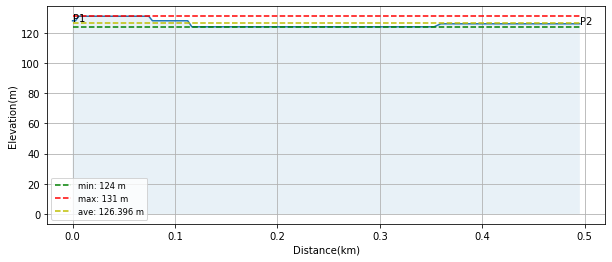

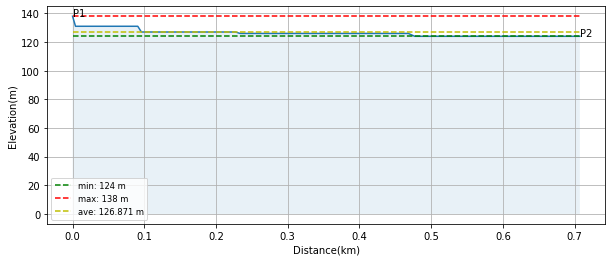

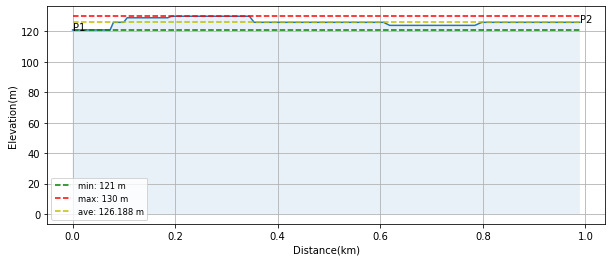

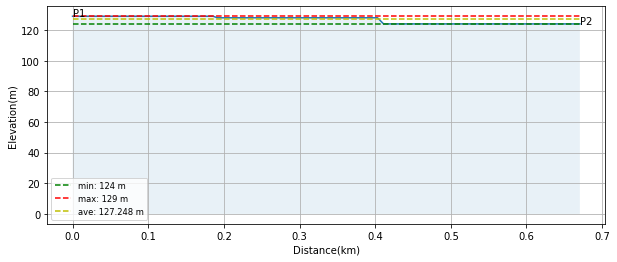

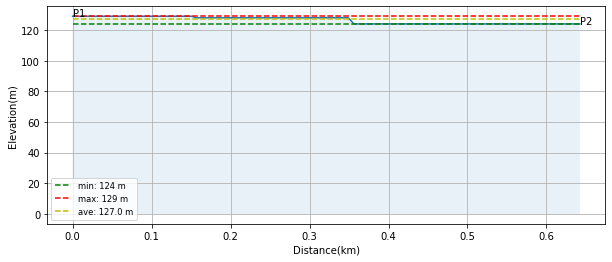

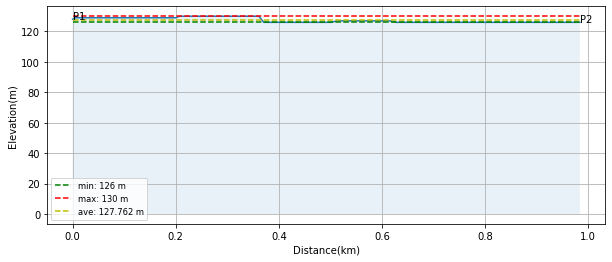

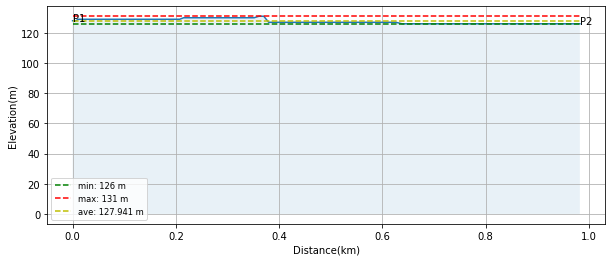

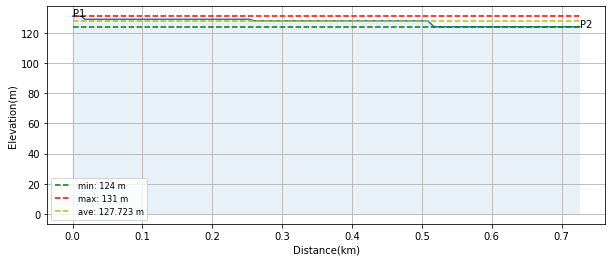

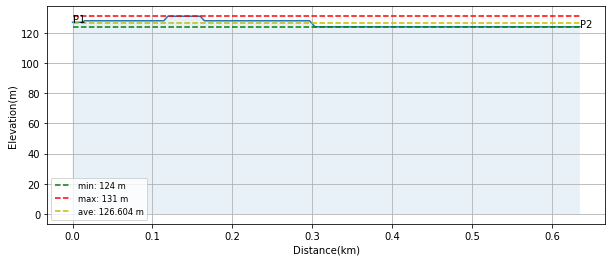

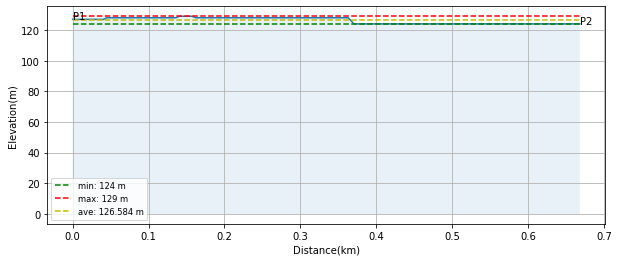

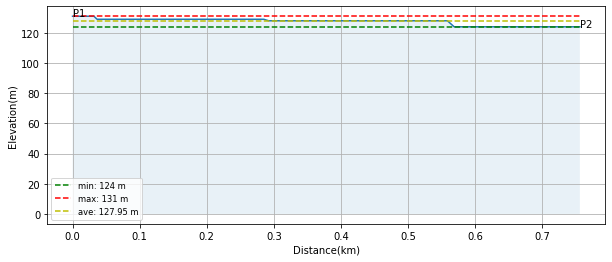

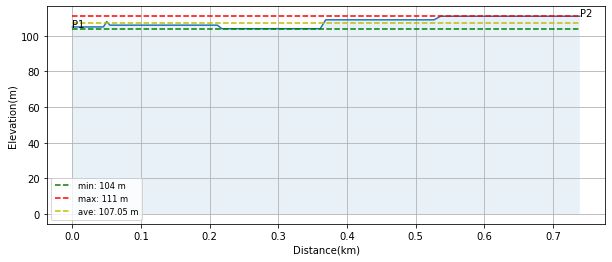

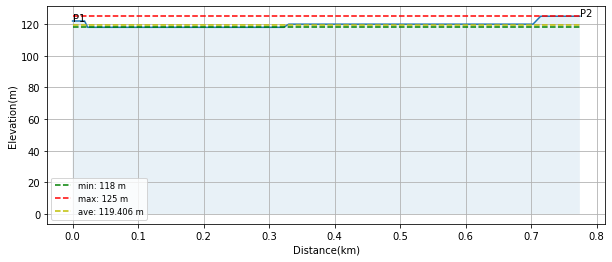

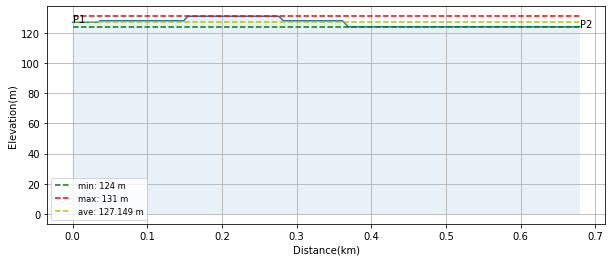

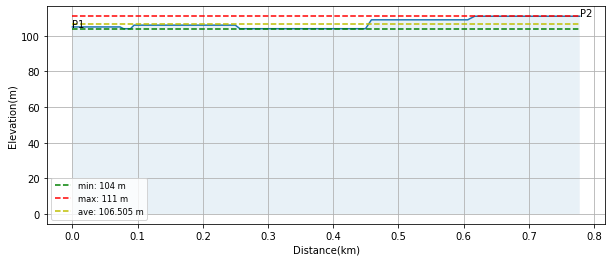

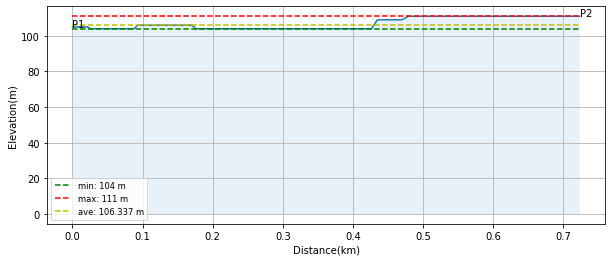

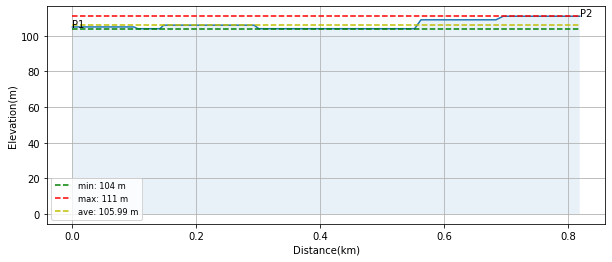

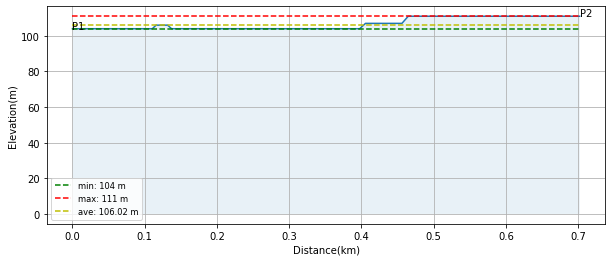

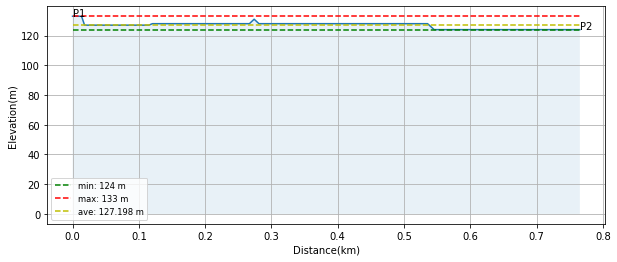

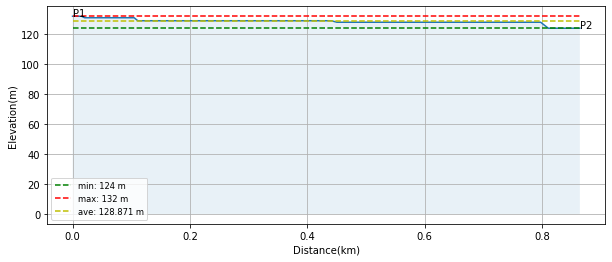

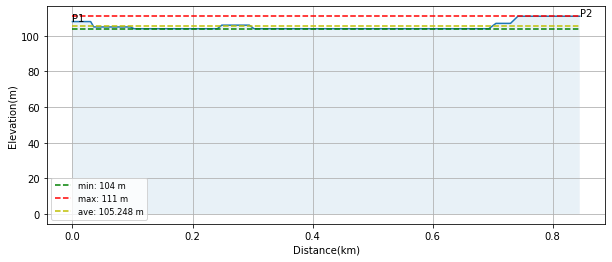

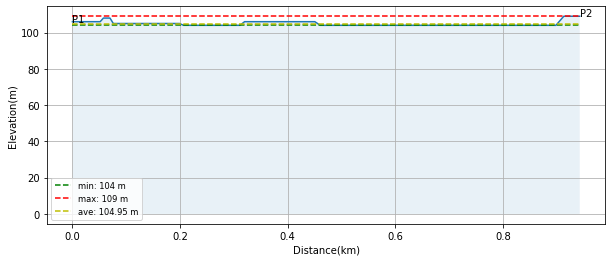

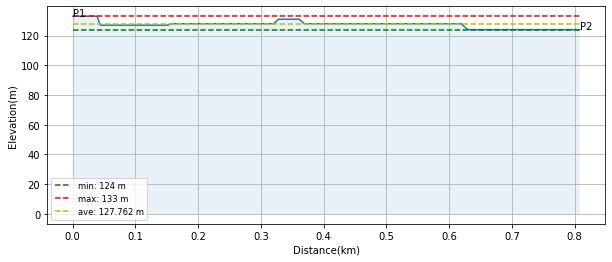

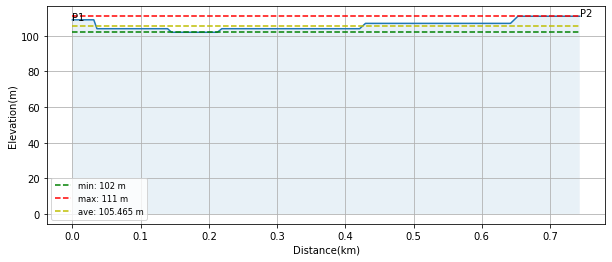

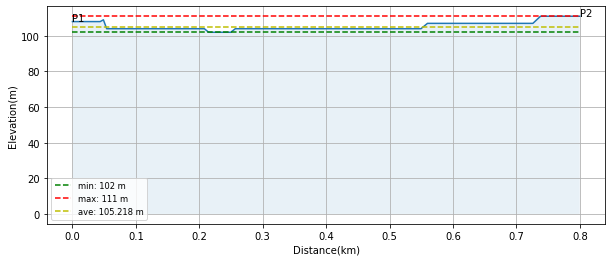

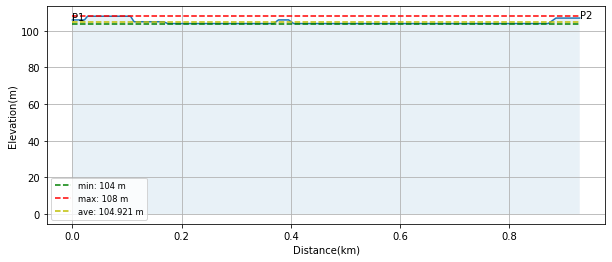

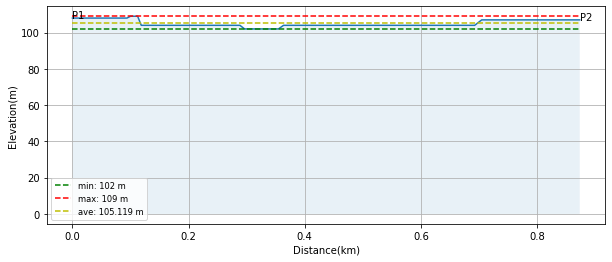

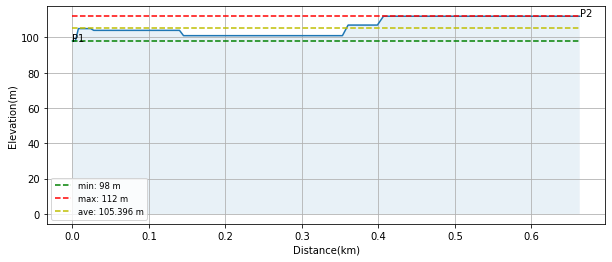

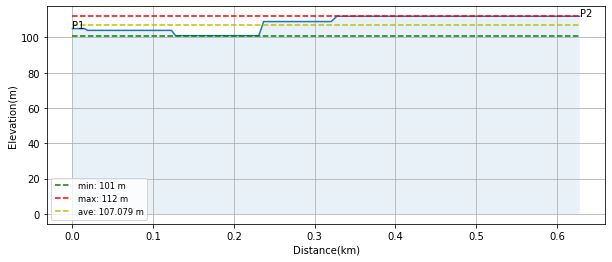

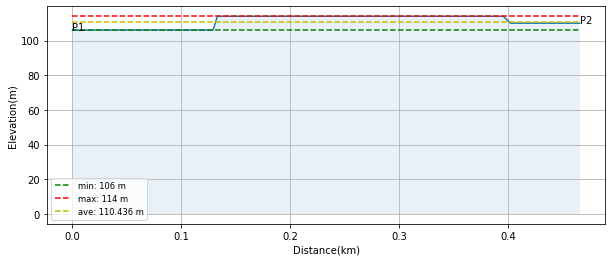

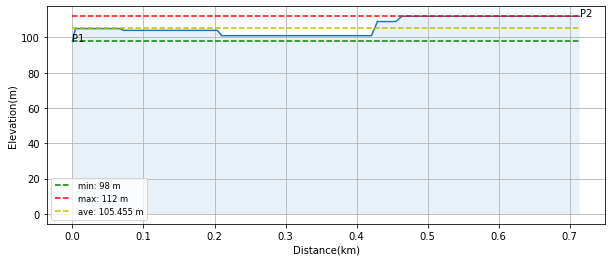

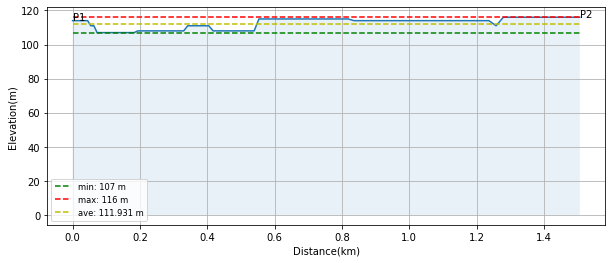

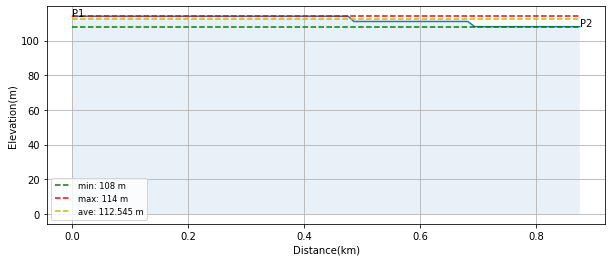

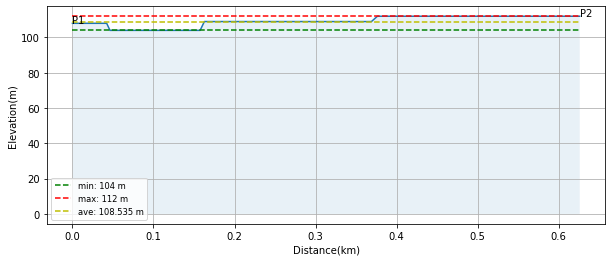

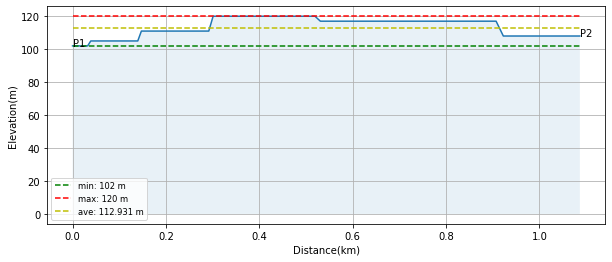

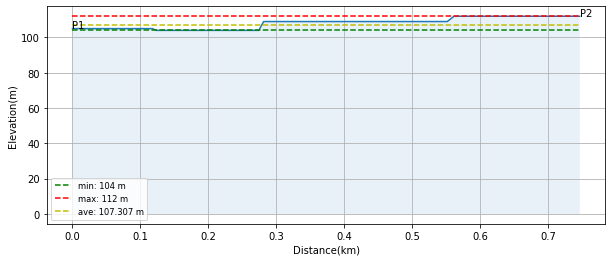

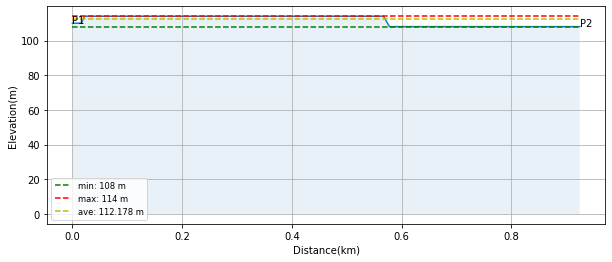

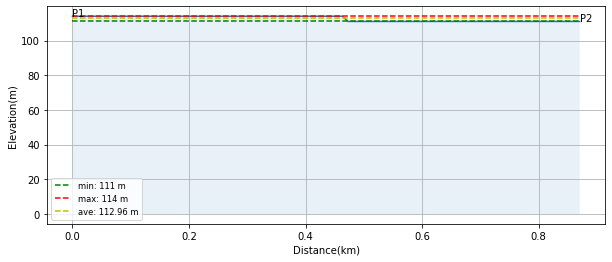

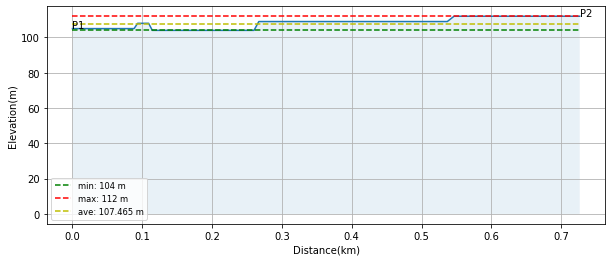

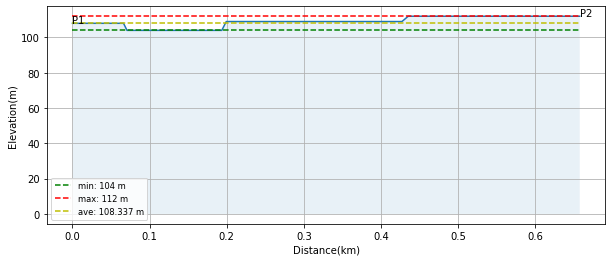

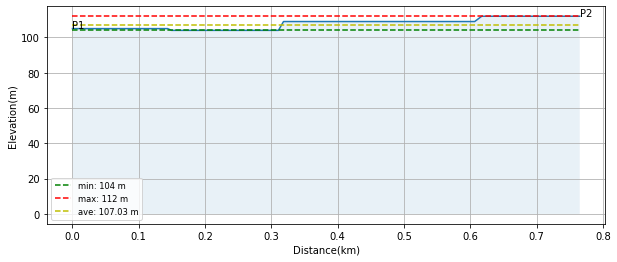

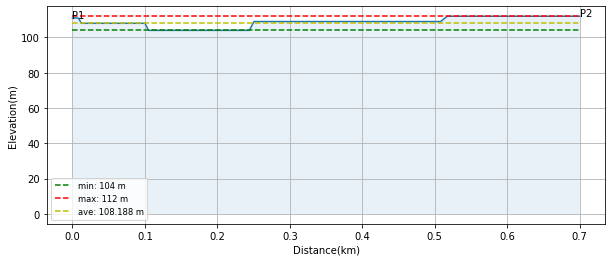

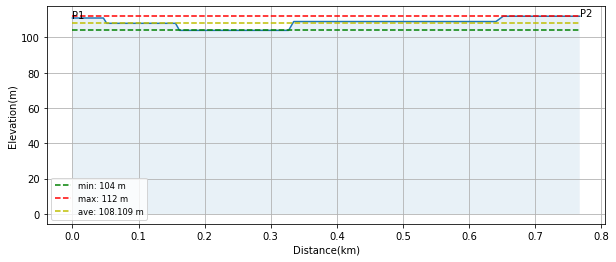

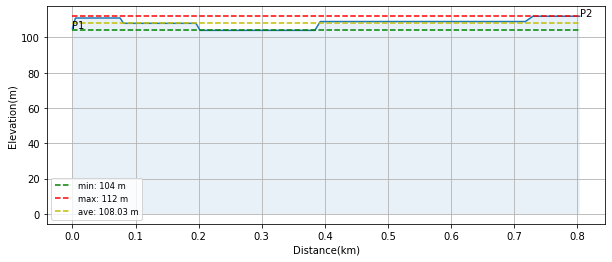

In [8]:
#Function to visulazie elevation between house and nearest store

def elevation_profile(index):
    
    def haversine(lat1, lon1, lat2, lon2):
        lat1_rad  = math.radians(lat1)
        lat2_rad  = math.radians(lat2)
        lon1_rad  = math.radians(lon1)
        lon2_rad  = math.radians(lon2)
        delta_lat = lat2_rad-lat1_rad
        delta_lon = lon2_rad-lon1_rad
        a = math.sqrt((math.sin(delta_lat/2))**2 + math.cos(lat1_rad)*math.cos(lat2_rad)*(math.sin(delta_lon/2))**2)
        return (2 * 6371000 * math.asin(a))
    
    P1 = [dataset.iloc[index, 0], dataset.iloc[index, 1]]
    P2 = [dataset.iloc[index, 4], dataset.iloc[index, 5]]

    lat_list = [P1[0]]
    lon_list = [P1[1]]

    for i in range(100):
        lat_step = P1[0] + ((P2[0] - P1[0]) / 100)
        lon_step = P1[1] + ((P2[1] - P1[1]) / 100)
        P1[1] = lon_step
        P1[0] = lat_step
        lat_list.append(lat_step)
        lon_list.append(lon_step)
        
    d_list = []
    
    for j in range(len(lat_list)):
        lat_p = lat_list[j]
        lon_p = lon_list[j]
        d_list.append(haversine(P1[0], P1[1], lat_p, lon_p)/1000)
        
    d_list_rev=d_list[::-1]

    d_ar = [{}]*len(lat_list)
    
    for i in range(len(lat_list)):
        d_ar[i] = {"latitude" : lat_list[i], "longitude" : lon_list[i]}
        
    location = {"locations" : d_ar}
    json_data = json.dumps(location, skipkeys = int).encode('utf8')

    url = 'https://api.open-elevation.com/api/v1/lookup'
    response = urllib.request.Request(url, json_data, headers = {'Content-Type': 'application/json'})
    fp = urllib.request.urlopen(response)
    res_byte = fp.read()
    res_str  = res_byte.decode("utf8")
    js_str   = json.loads(res_str)
    fp.close()

    response_len = len(js_str['results'])
    elev_list = []
    for j in range(response_len):
        elev_list.append(js_str['results'][j]['elevation'])

    mean_elev = round((sum(elev_list)/len(elev_list)), 3)
    min_elev  = min(elev_list)
    max_elev  = max(elev_list)
    distance  = d_list_rev[-1]

    base_reg = 0
    plt.figure(figsize = (10,4))
    plt.plot(d_list_rev, elev_list)
    plt.plot([0, distance], [min_elev, min_elev], '--g', label = 'min: ' + str(min_elev) + ' m')
    plt.plot([0, distance], [max_elev, max_elev], '--r', label = 'max: ' + str(max_elev) + ' m')
    plt.plot([0, distance], [mean_elev, mean_elev], '--y', label = 'ave: ' + str(mean_elev) + ' m')
    plt.fill_between(d_list_rev, elev_list, base_reg, alpha = 0.1)
    plt.text(d_list_rev[0], elev_list[0], 'P1')
    plt.text(d_list_rev[-1], elev_list[-1], 'P2')
    plt.xlabel('Distance(km)')
    plt.ylabel('Elevation(m)')
    plt.grid()
    plt.legend(fontsize = 'small')
    plt.savefig('Elevation_Profiles/index - {}.{}'.format(str(index), 'png'))
    
for index in range(len(dataset)):
    elevation_profile(index)